In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [49]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [50]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)

item_cnt_month = transactions.groupby(['shop_id', 'item_id', 'month', 'year'])['item_cnt_day'].sum().reset_index(name ='item_cnt_month')


item_cnt_month.item_cnt_month = np.clip(item_cnt_month.item_cnt_month, 0, 20)

In [51]:
month_year = set(list(zip(item_cnt_month.month, item_cnt_month.year)))
years = list(set([y for (m,y) in month_year]))
years.sort()
months = list(range(1,13))

date_to_int = {}

i = 1
for year in years:
    for month in months:
        date_to_int[(month,year)] = i
        i+=1
        
def get_date_int(row):
    return date_to_int[(row['month'], row['year'])]

item_cnt_month['date_counter'] = item_cnt_month.apply(get_date_int, axis=1)

In [52]:
w_cat_ids = item_cnt_month.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids['shop_cat_tuple'] = w_cat_ids.apply(lambda row: (row.shop_id, row.item_category_id),axis=1)

In [53]:
w_cat_ids['item_mean_month'] = w_cat_ids.groupby(w_cat_ids.index)['item_cnt_month'].mean()
w_cat_ids['shop_mean_month'] = w_cat_ids.groupby(w_cat_ids.shop_id)['item_cnt_month'].transform(np.mean)
w_cat_ids['category_mean_month'] = w_cat_ids.groupby(w_cat_ids.item_category_id)['item_cnt_month'].transform(np.mean)


In [54]:
november = w_cat_ids[w_cat_ids.month == 11]

item_november_means = november.groupby(november.index)['item_cnt_month'].mean()
item_november_means = item_november_means.reindex(index=w_cat_ids.index)
w_cat_ids['item_mean_november'] = item_november_means

category_november_means = november.groupby(november.item_category_id)['item_cnt_month'].mean()
category_november_means = category_november_means.reindex(index=w_cat_ids.index)
w_cat_ids['category_mean_november'] = category_november_means


shop_november_means = november.groupby(november.shop_id)['item_cnt_month'].mean()
shop_november_means = shop_november_means.reindex(index=w_cat_ids.index)
w_cat_ids['shop_mean_november'] = shop_november_means



In [55]:
w_cat_ids['item_shop_mean'] = w_cat_ids.groupby([w_cat_ids.index, w_cat_ids.shop_id])['item_cnt_month'].transform(np.mean)
w_cat_ids['category_shop_mean'] = w_cat_ids.groupby([w_cat_ids.item_category_id, w_cat_ids.shop_id])['item_cnt_month'].transform(np.mean)


In [56]:
import datetime
months = []
for i in range(1,13):
    months.append((i, str.lower(datetime.date(2008, i, 1).strftime('%B'))))
    
for i, month in months:
    w_cat_ids[month] = w_cat_ids.month == i
    

In [57]:
years = w_cat_ids.year.unique()
for year in years:
    w_cat_ids[year] = w_cat_ids.year == year
    
w_cat_ids.head()


shop_id  month  year  item_cnt_month  date_counter  \
item_id                                                       
0             54      9  2014             1.0            21   
1             55      4  2014             2.0            16   
1             55      7  2014             1.0            19   
1             55      8  2014             1.0            20   
1             55      9  2014             1.0            21   

                                                 item_name  item_category_id  \
item_id                                                                        
0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D                40   
1        !ABBYY FineReader 12 Professional Edition Full...                76   
1        !ABBYY FineReader 12 Professional Edition Full...                76   
1        !ABBYY FineReader 12 Professional Edition Full...                76   
1        !ABBYY FineReader 12 Professional Edition Full...                76   

        shop_cat_tuple  item_mean_month  shop_mean_month  ...     june   july  \
item_id                                                   ...                   
0             (54, 40)              1.0         2.286941  ...    False  False   
1             (55, 76)              1.2         3.081936  ...    False  False   
1             (55, 76)              1.2         3.081936  ...    False   True   
1             (55, 76)              1.2         3.081936  ...    False  False   
1             (55, 76)              1.2         3.081936  ...    False  False   

         august  september  october  november  december  2014   2015   2013  
item_id                                                                      
0         False       True    False     False     False  True  False  False  
1         False      False    False     False     False  True  False  False  
1         False      False    False     False     False  True  False  False  
1          True      False    False     False     False  True  False  False  
1         False       True    False     False     False  True  False  False  

[5 rows x 31 columns]

In [58]:
Q3 = w_cat_ids[w_cat_ids.month.isin([10,11,12])]

item_id_Q3_means = Q3.groupby(Q3.index)['item_cnt_month'].mean()
item_id_Q3_means = item_id_Q3_means.reindex(index=w_cat_ids.index)
w_cat_ids['item_mean_Q3'] = item_id_Q3_means

category_Q3_means = Q3.groupby(Q3.item_category_id)['item_cnt_month'].mean()
category_Q3_means = category_Q3_means.reindex(index=w_cat_ids.index)
w_cat_ids['category_mean_Q3'] = category_Q3_means


shop_Q3_means = Q3.groupby(Q3.shop_id)['item_cnt_month'].mean()
shop_Q3_means = shop_Q3_means.reindex(index=w_cat_ids.index)
w_cat_ids['shop_mean_Q3'] = shop_Q3_means



In [59]:
def get_coeffs_for_shop(shop_id, poly_degree=1, print_chart=False):

    shop = w_cat_ids[w_cat_ids.shop_id == shop_id].groupby('date_counter')['item_cnt_month'].sum().reset_index(name ='item_cnt')

    datax = shop.date_counter.values
    datay = shop.item_cnt.values

    z = np.polyfit(datax,datay, poly_degree) 
    p = np.poly1d(z)

    shop['poly'] = shop['date_counter'].apply(lambda x: p(x))

    if print_chart:
        sns.set()
        fig, ax = plt.subplots()
        shop.plot(x='date_counter', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        shop.plot(x='date_counter', y='poly', ax=ax, legend=False, figsize=(15,7))

    return p.coefficients

In [60]:
shop_ids = w_cat_ids.shop_id.unique()
slopes = {}

for shop_id in shop_ids:
    slope = get_coeffs_for_shop(shop_id)[0]
    slopes[shop_id] = slope

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


In [61]:
w_cat_ids['shop_slope'] = w_cat_ids.apply(lambda row: slopes[row['shop_id']], axis=1)

In [62]:
w_cat_ids['is_Q3'] = w_cat_ids.month.isin([10,11,12])


w_cat_ids['positive_trend'] = w_cat_ids.shop_slope > 0


w_cat_ids.head()

shop_id  month  year  item_cnt_month  date_counter  \
item_id                                                       
0             54      9  2014             1.0            21   
1             55      4  2014             2.0            16   
1             55      7  2014             1.0            19   
1             55      8  2014             1.0            20   
1             55      9  2014             1.0            21   

                                                 item_name  item_category_id  \
item_id                                                                        
0                ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D                40   
1        !ABBYY FineReader 12 Professional Edition Full...                76   
1        !ABBYY FineReader 12 Professional Edition Full...                76   
1        !ABBYY FineReader 12 Professional Edition Full...                76   
1        !ABBYY FineReader 12 Professional Edition Full...                76   

        shop_cat_tuple  item_mean_month  shop_mean_month       ...        \
item_id                                                        ...         
0             (54, 40)              1.0         2.286941       ...         
1             (55, 76)              1.2         3.081936       ...         
1             (55, 76)              1.2         3.081936       ...         
1             (55, 76)              1.2         3.081936       ...         
1             (55, 76)              1.2         3.081936       ...         

         december  2014   2015   2013  item_mean_Q3  category_mean_Q3  \
item_id                                                                 
0           False  True  False  False           NaN               NaN   
1           False  True  False  False           1.0               NaN   
1           False  True  False  False           1.0               NaN   
1           False  True  False  False           1.0               NaN   
1           False  True  False  False           1.0               NaN   

         shop_mean_Q3  shop_slope  is_Q3  positive_trend  
item_id                                                   
0                 NaN -142.460044  False           False  
1                 NaN   37.342380  False            True  
1                 NaN   37.342380  False            True  
1                 NaN   37.342380  False            True  
1                 NaN   37.342380  False            True  

[5 rows x 37 columns]

In [196]:
train = w_cat_ids
#train = w_cat_ids[w_cat_ids.month == 11]

y = train.item_cnt_month

#train = nov[['shop_id', 'date_counter', 'item_category_id', 'item_mean_month', 'shop_mean_month', 'category_mean_month', 'item_mean_november', 'category_mean_november', 'shop_mean_november', 'item_shop_mean', 'category_shop_mean', 'item_mean_Q3', 'category_mean_Q3', 'shop_mean_Q3', 'shop_slope']]

cols = ['shop_id', 'item_category_id', 'item_mean_month', 'shop_mean_month', 
             'category_mean_month',  
             'item_shop_mean', 'category_shop_mean',
             'is_Q3', 'positive_trend']

for _, month in months:
    cols.append(month)
    
for year in years:
    cols.append(year)
    
train = train[cols]



train['item_id'] = train.index
train.head()

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


shop_id  item_category_id  item_mean_month  shop_mean_month  \
item_id                                                                
0             54                40              1.0         2.286941   
1             55                76              1.2         3.081936   
1             55                76              1.2         3.081936   
1             55                76              1.2         3.081936   
1             55                76              1.2         3.081936   

         category_mean_month  item_shop_mean  category_shop_mean  is_Q3  \
item_id                                                                   
0                   1.811020             1.0            2.233672  False   
1                   2.708738             1.2            2.708738  False   
1                   2.708738             1.2            2.708738  False   
1                   2.708738             1.2            2.708738  False   
1                   2.708738             1.2            2.708738  False   

         positive_trend  january   ...      july  august  september  october  \
item_id                            ...                                         
0                 False    False   ...     False   False       True    False   
1                  True    False   ...     False   False      False    False   
1                  True    False   ...      True   False      False    False   
1                  True    False   ...     False    True      False    False   
1                  True    False   ...     False   False       True    False   

         november  december  2014   2015   2013  item_id  
item_id                                                   
0           False     False  True  False  False        0  
1           False     False  True  False  False        1  
1           False     False  True  False  False        1  
1           False     False  True  False  False        1  
1           False     False  True  False  False        1  

[5 rows x 25 columns]

In [197]:
x_train, x_val, y_train, y_val = train_test_split(train, y, test_size=0.1, random_state=42)

train.head()

shop_id  item_category_id  item_mean_month  shop_mean_month  \
item_id                                                                
0             54                40              1.0         2.286941   
1             55                76              1.2         3.081936   
1             55                76              1.2         3.081936   
1             55                76              1.2         3.081936   
1             55                76              1.2         3.081936   

         category_mean_month  item_shop_mean  category_shop_mean  is_Q3  \
item_id                                                                   
0                   1.811020             1.0            2.233672  False   
1                   2.708738             1.2            2.708738  False   
1                   2.708738             1.2            2.708738  False   
1                   2.708738             1.2            2.708738  False   
1                   2.708738             1.2            2.708738  False   

         positive_trend  january   ...      july  august  september  october  \
item_id                            ...                                         
0                 False    False   ...     False   False       True    False   
1                  True    False   ...     False   False      False    False   
1                  True    False   ...      True   False      False    False   
1                  True    False   ...     False    True      False    False   
1                  True    False   ...     False   False       True    False   

         november  december  2014   2015   2013  item_id  
item_id                                                   
0           False     False  True  False  False        0  
1           False     False  True  False  False        1  
1           False     False  True  False  False        1  
1           False     False  True  False  False        1  
1           False     False  True  False  False        1  

[5 rows x 25 columns]

In [198]:
lgtrain = lgbm.Dataset(x_train, label=y_train)
lgval = lgbm.Dataset(x_val, label=y_val)



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        "learning_rate" : 0.05,
        #"num_leaves": 29,
        #"max_depth" : 24,
        #"bagging_fraction": 0.4,
        #"bagging_freq": 1,
        #"feature_fraction": 0.68,
        #"lambda_l1": 10,
}


In [199]:
evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 50000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.71812
[200]	valid_0's rmse: 1.67125
[300]	valid_0's rmse: 1.63956
[400]	valid_0's rmse: 1.61982
[500]	valid_0's rmse: 1.59965
[600]	valid_0's rmse: 1.58013
[700]	valid_0's rmse: 1.56605
[800]	valid_0's rmse: 1.55287
[900]	valid_0's rmse: 1.54181
[1000]	valid_0's rmse: 1.53201
[1100]	valid_0's rmse: 1.52388
[1200]	valid_0's rmse: 1.51686
[1300]	valid_0's rmse: 1.51111
[1400]	valid_0's rmse: 1.50521
[1500]	valid_0's rmse: 1.49885
[1600]	valid_0's rmse: 1.49425
[1700]	valid_0's rmse: 1.48834
[1800]	valid_0's rmse: 1.48287
[1900]	valid_0's rmse: 1.47807
[2000]	valid_0's rmse: 1.47454
[2100]	valid_0's rmse: 1.46968
[2200]	valid_0's rmse: 1.46619
[2300]	valid_0's rmse: 1.4624
[2400]	valid_0's rmse: 1.4585
[2500]	valid_0's rmse: 1.45378
[2600]	valid_0's rmse: 1.4513
[2700]	valid_0's rmse: 1.44813
[2800]	valid_0's rmse: 1.4439
[2900]	valid_0's rmse: 1.44043
[3000]	valid_0's rmse: 1.437
[3100]	valid_0's rmse:

In [203]:
cols

['shop_id',
 'item_category_id',
 'item_mean_month',
 'shop_mean_month',
 'category_mean_month',
 'item_shop_mean',
 'category_shop_mean',
 'is_Q3',
 'positive_trend',
 'january',
 'february',
 'march',
 'april',
 'may',
 'june',
 'july',
 'august',
 'september',
 'october',
 'november',
 'december',
 2014,
 2015,
 2013]

In [86]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

test_w_cat_ids.head()

ID  shop_id                   item_name  item_category_id  item_id
item_id                                                                       
30        2587        5  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40       30
30        7687        4  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40       30
30       12787        6  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40       30
30       17887        3  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40       30
30       22987        2  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40       30

In [182]:
shop_level_data = w_cat_ids.drop_duplicates(['shop_id'])
shop_level_data = shop_level_data.set_index('shop_id')

test_w_cat_ids['shop_mean_month'] = test_w_cat_ids.shop_id.map(shop_level_data.shop_mean_month)
test_w_cat_ids['shop_mean_Q3'] = test_w_cat_ids.shop_id.map(shop_level_data.shop_mean_Q3)
test_w_cat_ids['shop_slope'] = test_w_cat_ids.shop_id.map(shop_level_data.shop_slope)
test_w_cat_ids['positive_trend'] = test_w_cat_ids.shop_id.map(shop_level_data.positive_trend)
test_w_cat_ids['category_shop_mean'] = test_w_cat_ids.shop_id.map(shop_level_data.category_shop_mean)
test_w_cat_ids['item_shop_mean'] = test_w_cat_ids.shop_id.map(shop_level_data.item_shop_mean)
test_w_cat_ids['shop_mean_november'] = test_w_cat_ids.shop_id.map(shop_level_data.shop_mean_november)





In [135]:
w_cat_ids['item_id'] = w_cat_ids.index

In [183]:
item_level_data = w_cat_ids.drop_duplicates(['item_id'])


test_w_cat_ids['item_mean_month'] = test_w_cat_ids.item_id.map(item_level_data.item_mean_month)
test_w_cat_ids['category_mean_month'] = test_w_cat_ids.item_id.map(item_level_data.category_mean_month)
test_w_cat_ids['item_mean_Q3'] = test_w_cat_ids.item_id.map(item_level_data.item_mean_Q3)
test_w_cat_ids['category_mean_Q3'] = test_w_cat_ids.item_id.map(item_level_data.category_mean_Q3)
test_w_cat_ids['item_mean_november'] = test_w_cat_ids.item_id.map(item_level_data.item_mean_november)
test_w_cat_ids['category_mean_november'] = test_w_cat_ids.item_id.map(item_level_data.category_mean_november)




In [149]:
for i, month in months:
    test_w_cat_ids[month] = False
    
test_w_cat_ids['november'] = True
    
for year in years:
    test_w_cat_ids[year] = False
    
test_w_cat_ids[2015] = True

test_w_cat_ids['is_Q3'] = True


    
test_w_cat_ids.head()


ID  shop_id                   item_name  item_category_id  \
item_id                                                                 
30        2587        5  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
30        7687        4  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
30       12787        6  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
30       17887        3  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   
30       22987        2  007: КООРДИНАТЫ «СКАЙФОЛЛ»                40   

         item_id  shop_mean_month  shop_mean_Q3  shop_slope  positive_trend  \
item_id                                                                       
30            30         1.689813       2.70767   -6.519051           False   
30            30         1.735184       2.70767  -27.048892           False   
30            30         1.925757       2.70767  -69.419404           False   
30            30         1.627503       2.70767   -4.004584           False   
30            30         1.857519       2.70767    2.735829            True   

         item_mean_month  ...    august  september  october  november  \
item_id                   ...                                           
30              3.473029  ...     False      False    False      True   
30              3.473029  ...     False      False    False      True   
30              3.473029  ...     False      False    False      True   
30              3.473029  ...     False      False    False      True   
30              3.473029  ...     False      False    False      True   

         december   2014  2015   2013  item_shop_mean  is_Q3  
item_id                                                       
30          False  False  True  False             1.0   True  
30          False  False  True  False             1.0   True  
30          False  False  True  False             1.0   True  
30          False  False  True  False             1.0   True  
30          False  False  True  False             1.0   True  

[5 rows x 31 columns]

In [200]:

lg_preds = model_lgb.predict(test_w_cat_ids[cols])
lg_preds = np.clip(lg_preds, 0 ,20)

In [201]:
submission = test_w_cat_ids.loc[:,['ID']]
submission['item_cnt_month'] = lg_preds

submission.to_csv('submission.csv', index=False)

In [202]:
len(np.unique(lg_preds))

69602

In [236]:
def get_coeffs_for_shop(shop_id, poly_degree=1, print_chart=False):

    shop = w_cat_ids[w_cat_ids.shop_id == shop_id].groupby('date_counter')['item_cnt_month'].sum().reset_index(name ='item_cnt')

    datax = shop.date_counter.values
    datay = shop.item_cnt.values

    z = np.polyfit(datax,datay, poly_degree) 
    p = np.poly1d(z)

    shop['poly'] = shop['date_counter'].apply(lambda x: p(x))

    if print_chart:
        sns.set()
        fig, ax = plt.subplots()
        shop.plot(x='date_counter', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        shop.plot(x='date_counter', y='poly', ax=ax, legend=False, figsize=(15,7))

    return p

def get_coeffs_for_category(category_id, poly_degree=1, print_chart=False):

    cat = w_cat_ids[w_cat_ids.item_category_id == category_id].groupby('date_counter')['item_cnt_month'].sum().reset_index(name ='item_cnt')

    datax = cat.date_counter.values
    datay = cat.item_cnt.values

    z = np.polyfit(datax,datay, poly_degree) 
    p = np.poly1d(z)

    cat['poly'] = cat['date_counter'].apply(lambda x: p(x))

    if print_chart:
        sns.set()
        fig, ax = plt.subplots()
        cat.plot(x='date_counter', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        cat.plot(x='date_counter', y='poly', ax=ax, legend=False, figsize=(15,7))

    return p

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  


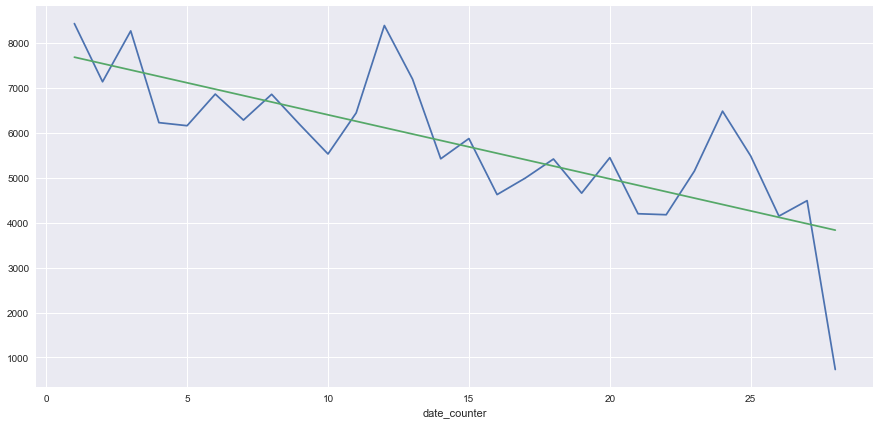

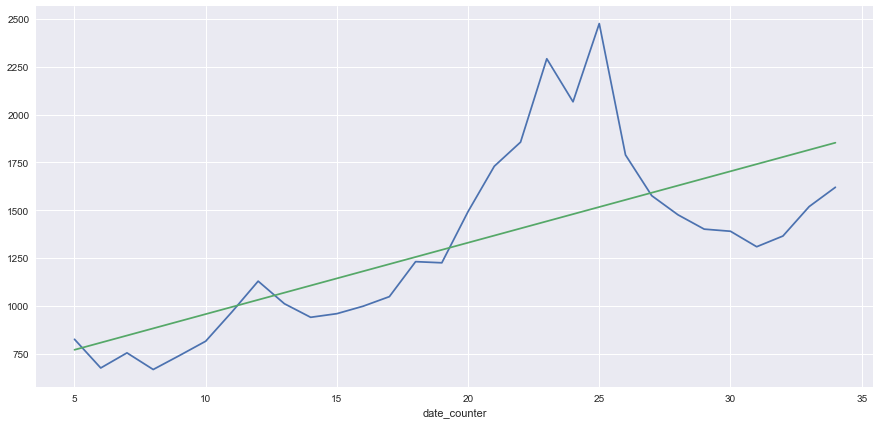

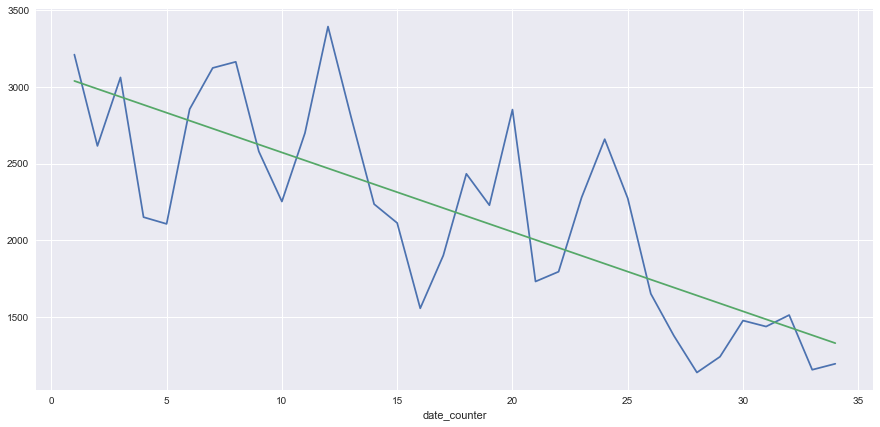

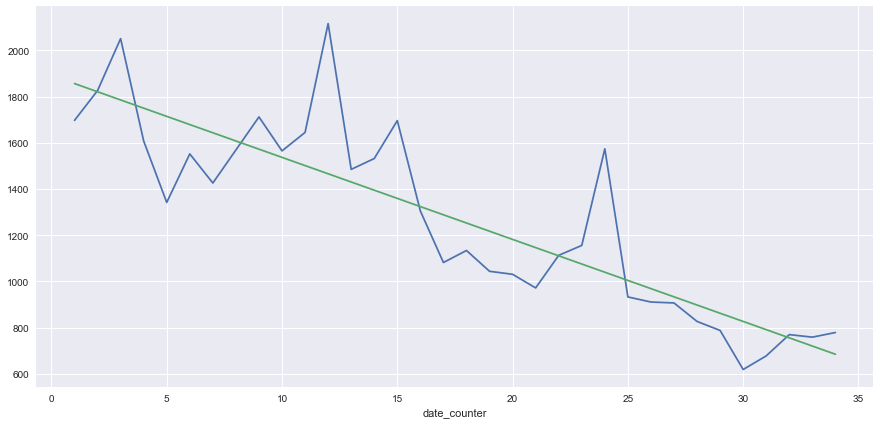

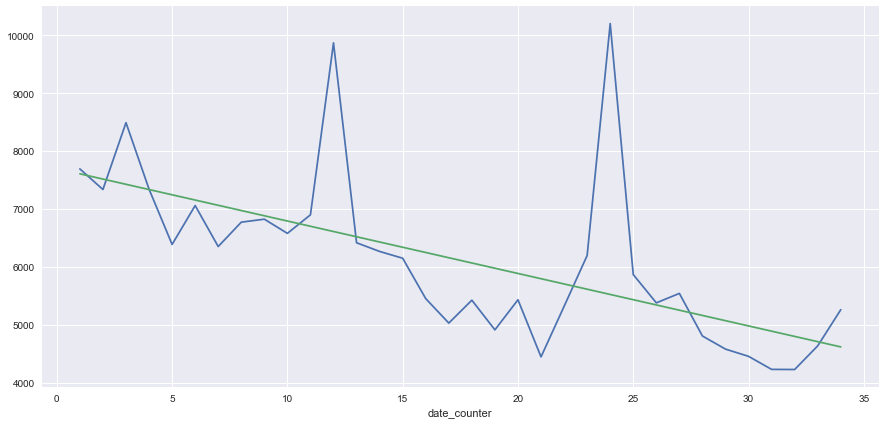

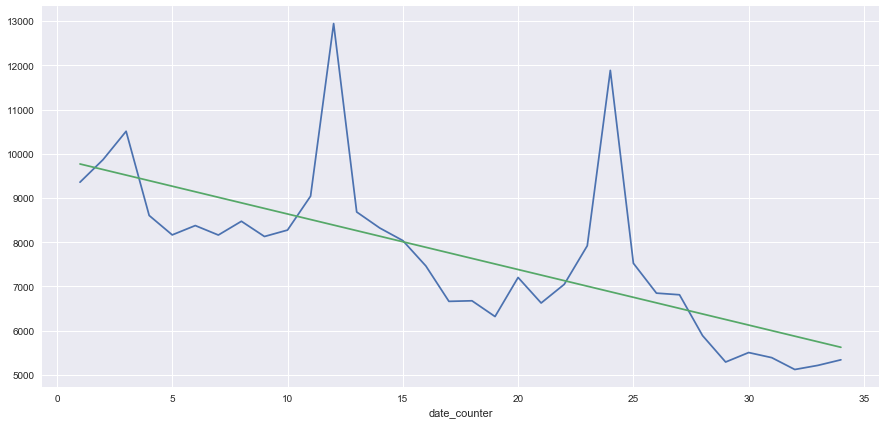

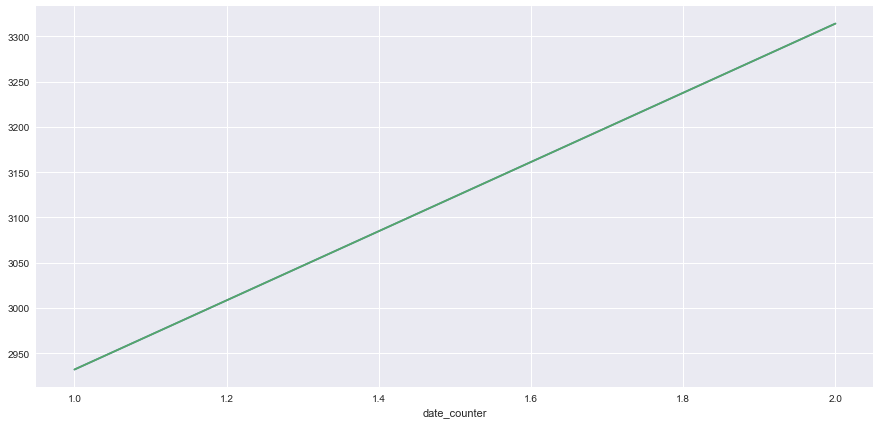

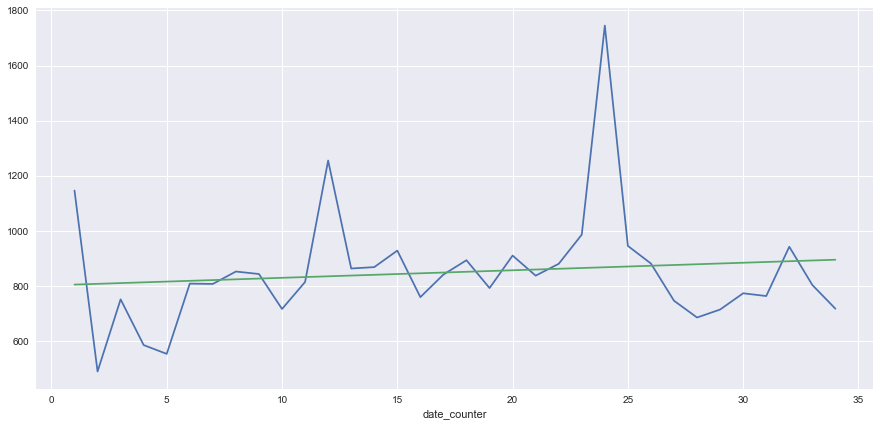

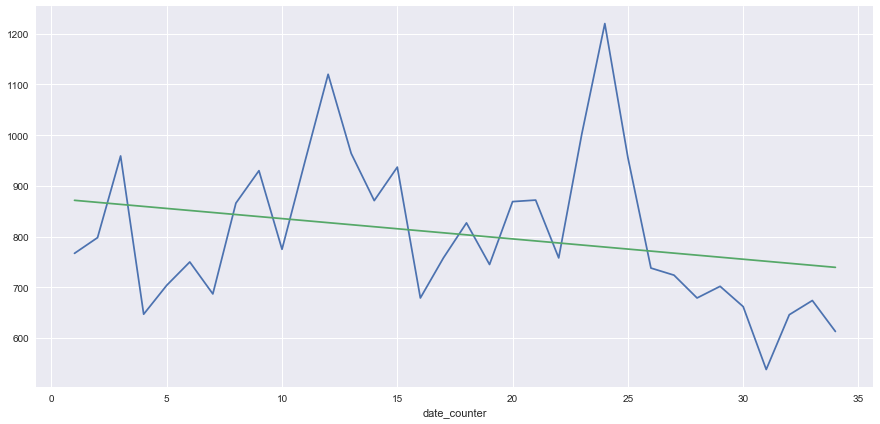

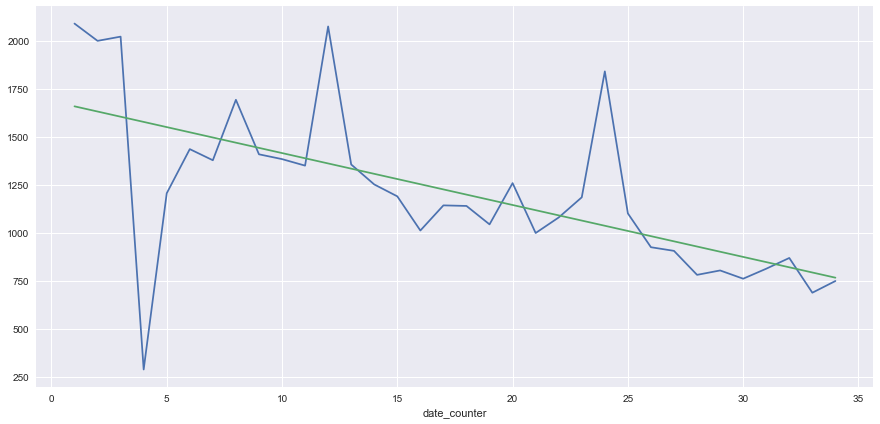

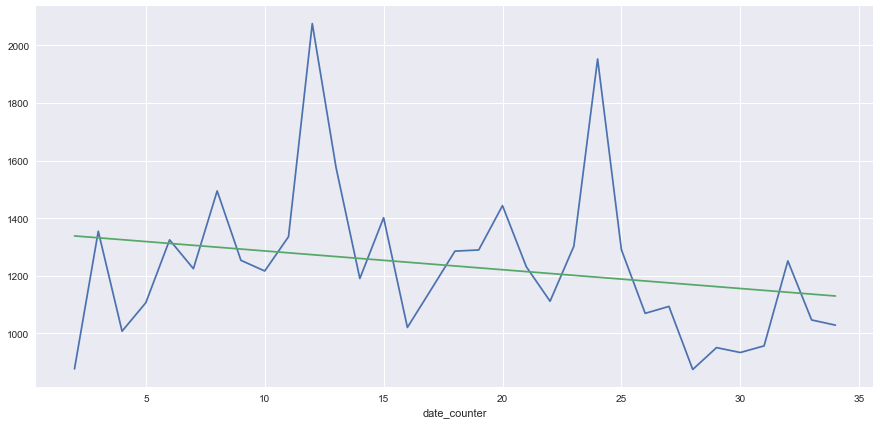

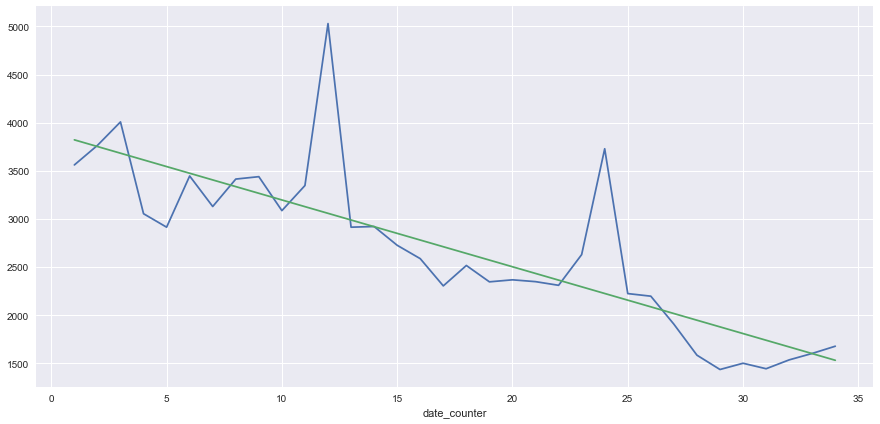

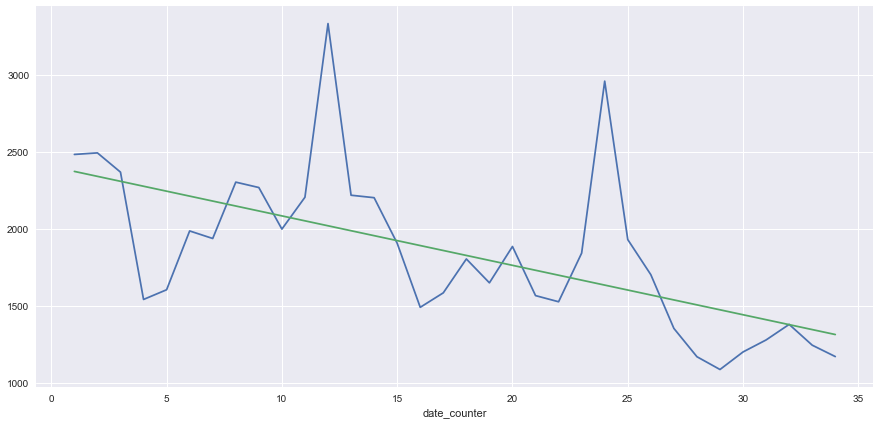

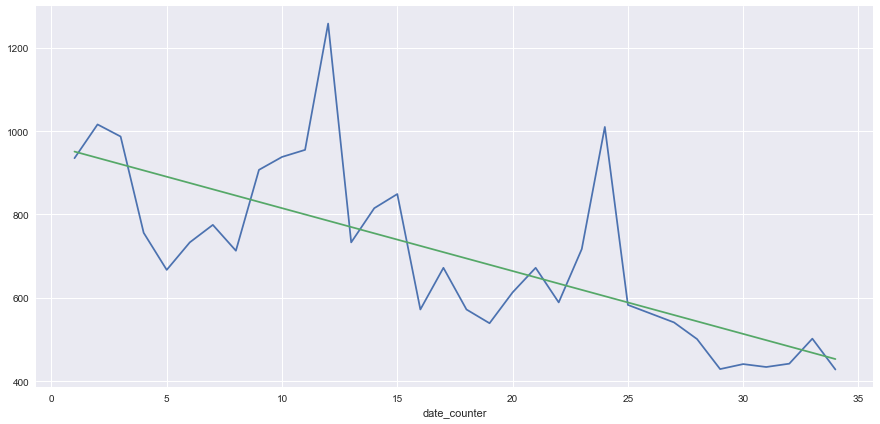

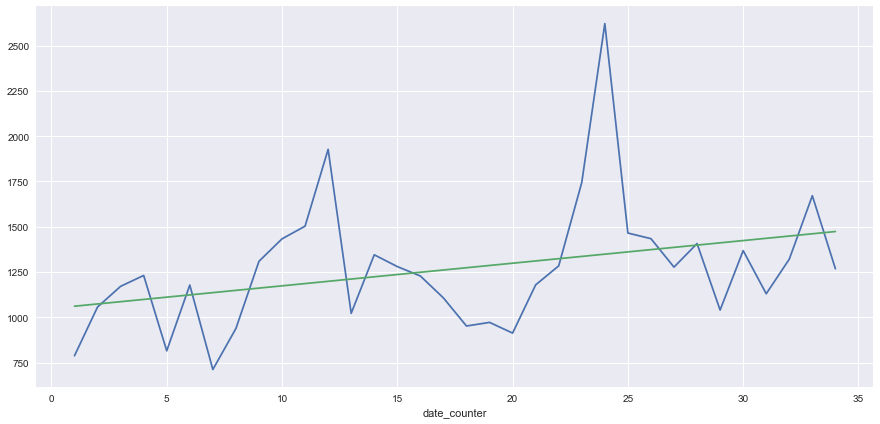

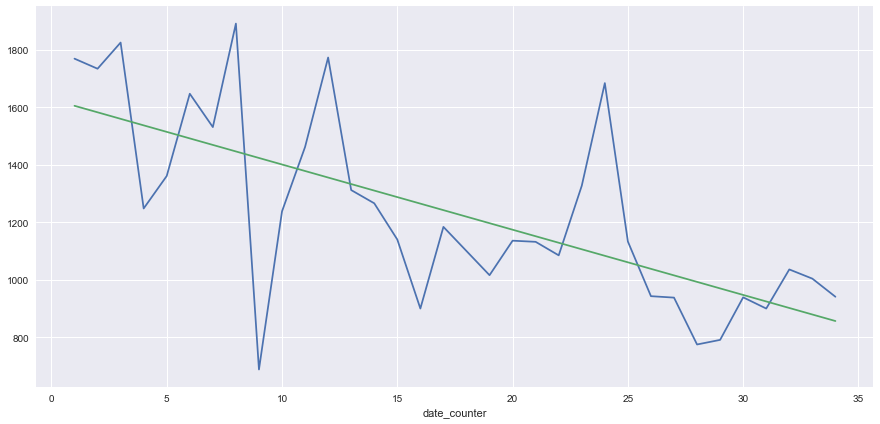

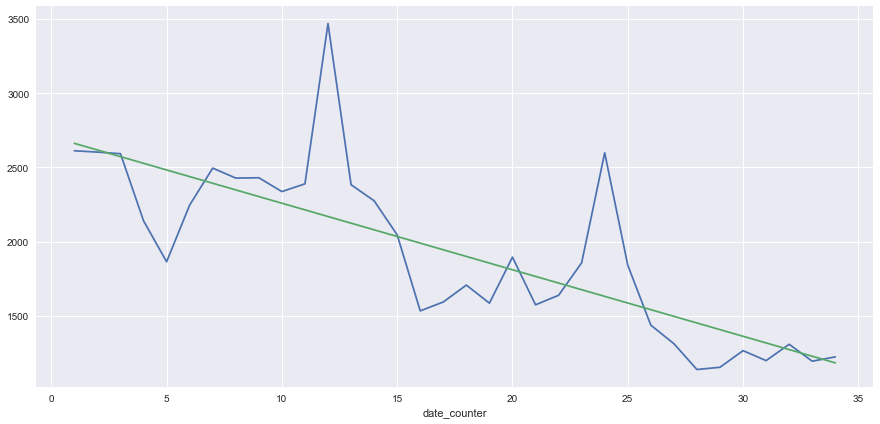

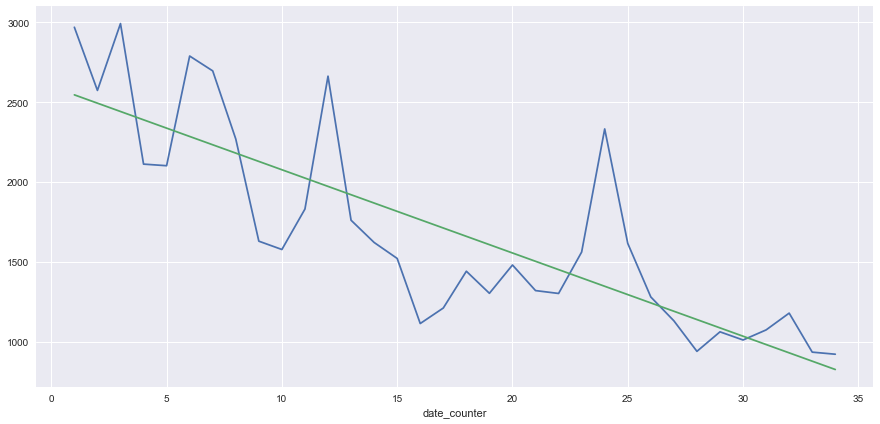

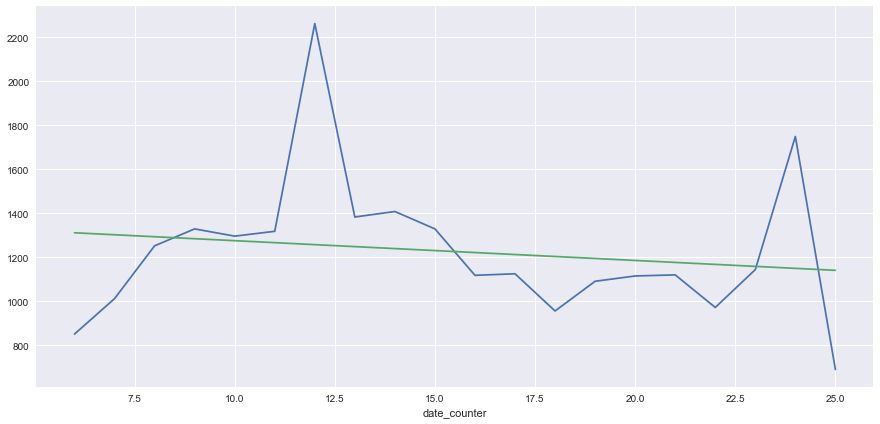

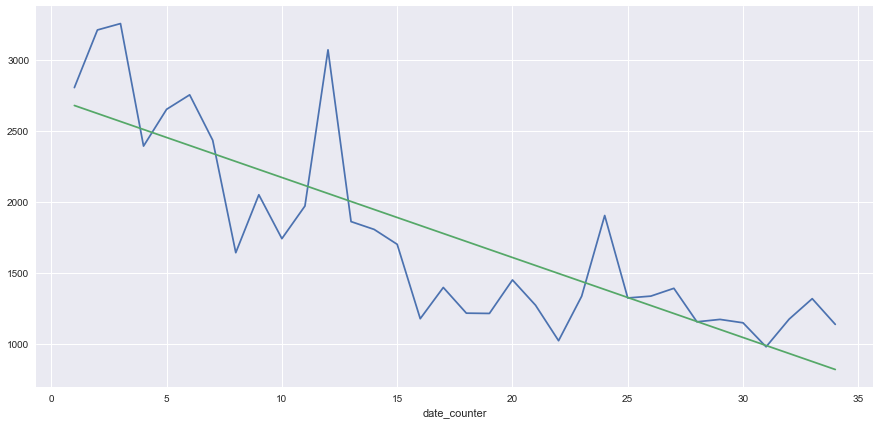

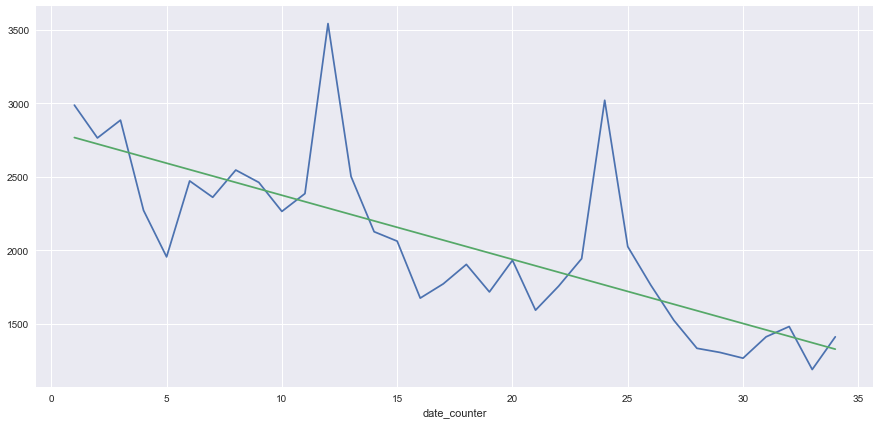

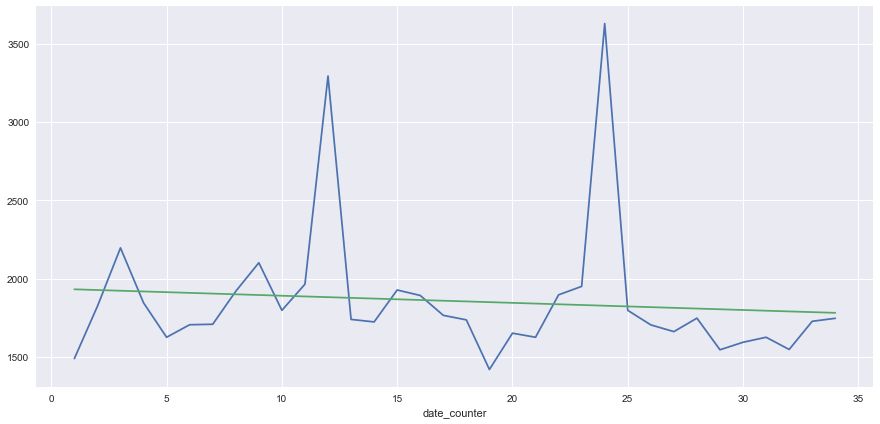

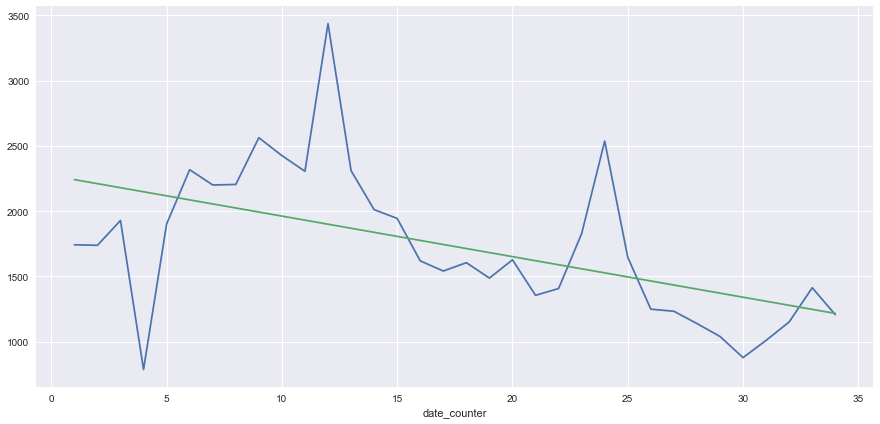

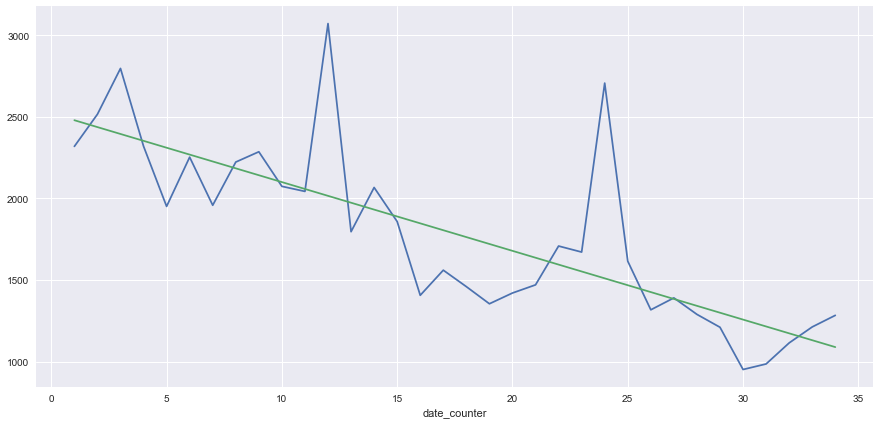

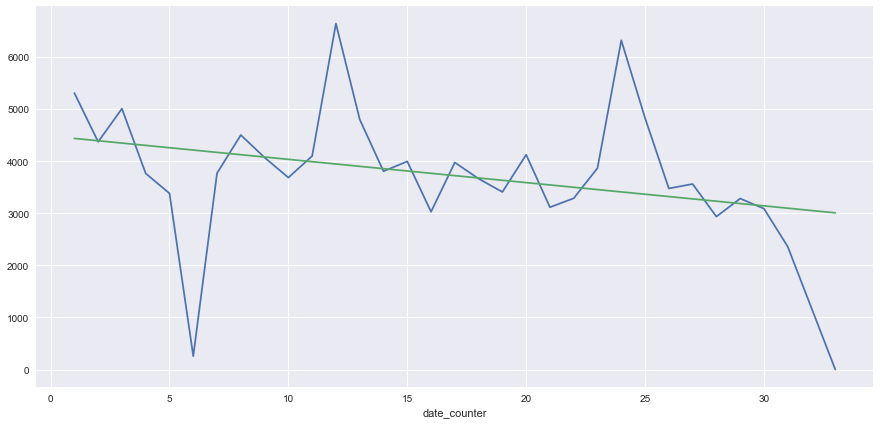

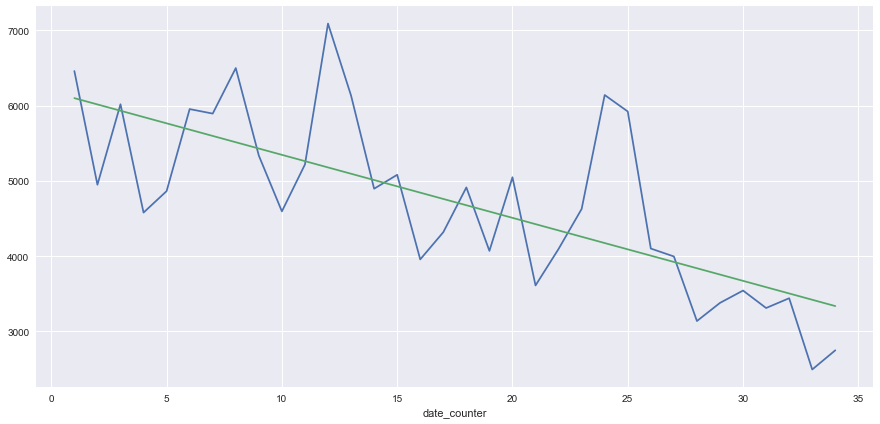

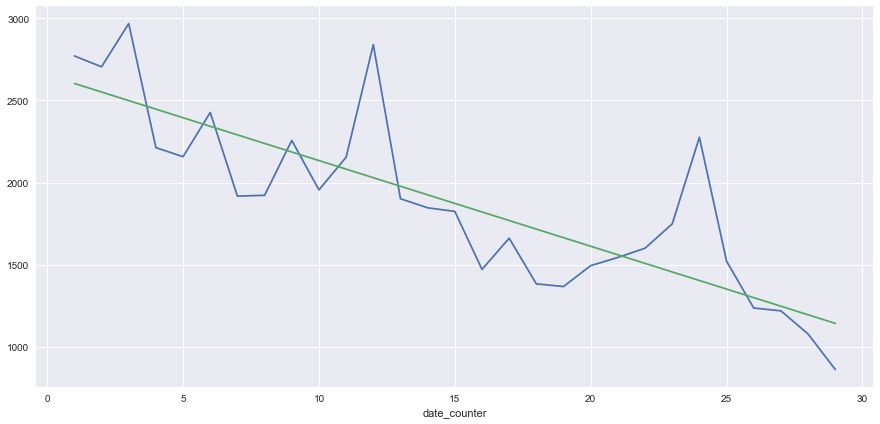

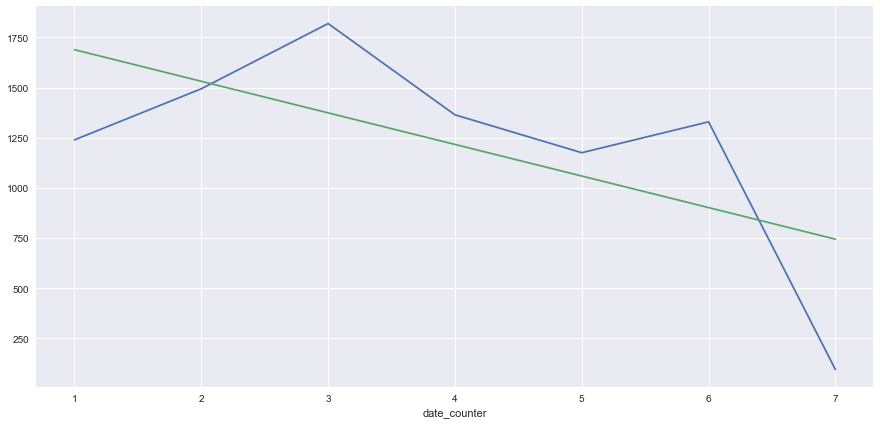

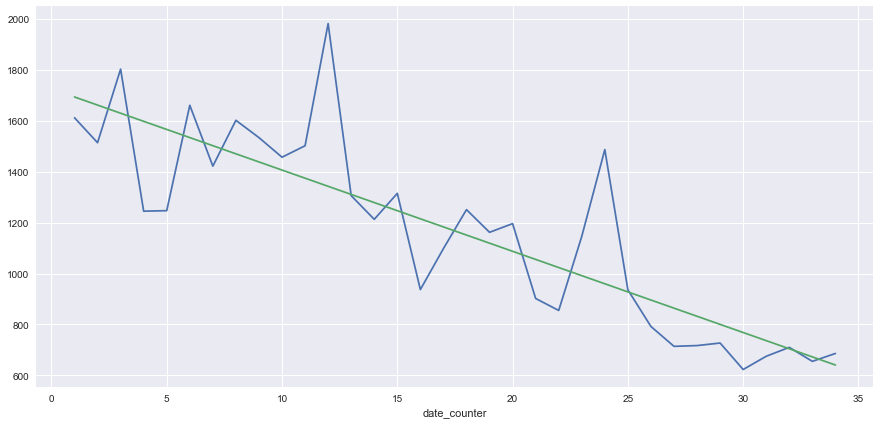

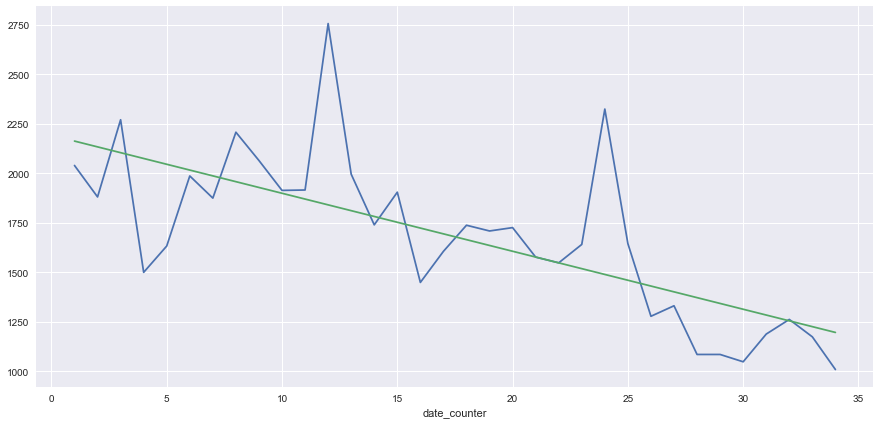

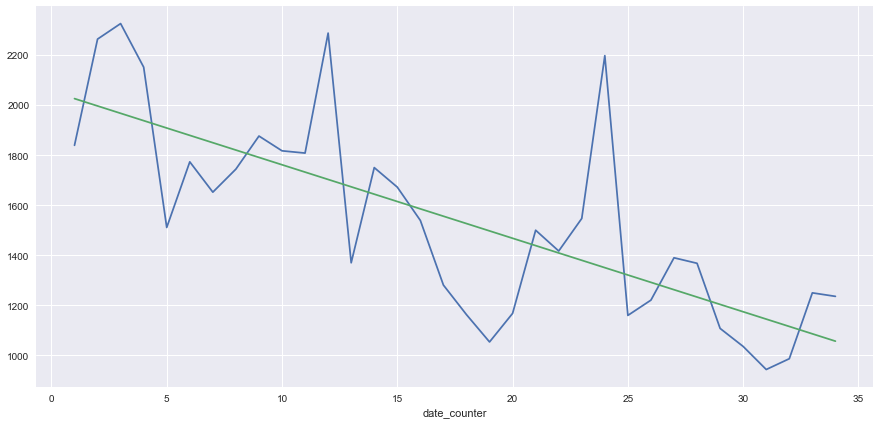

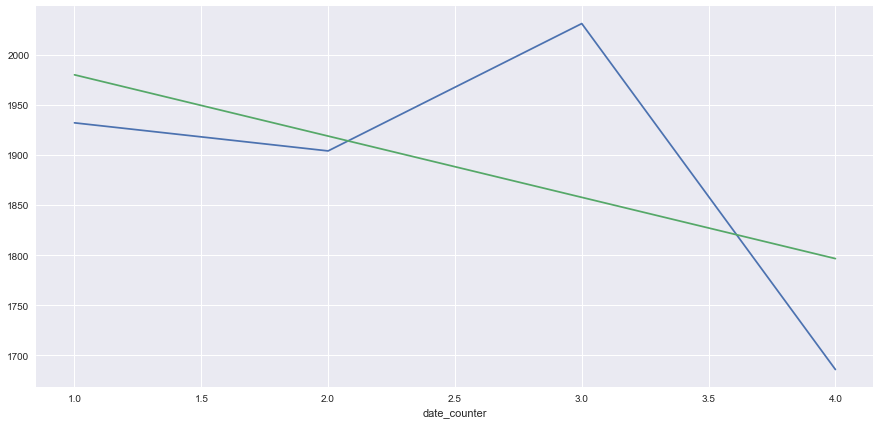

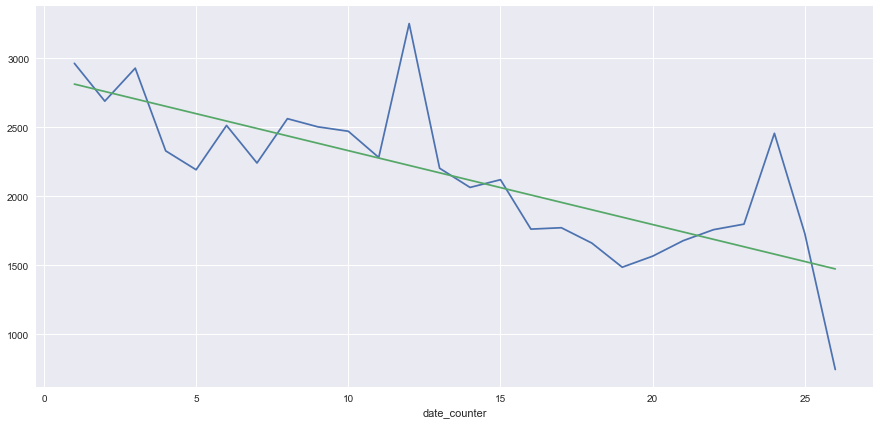

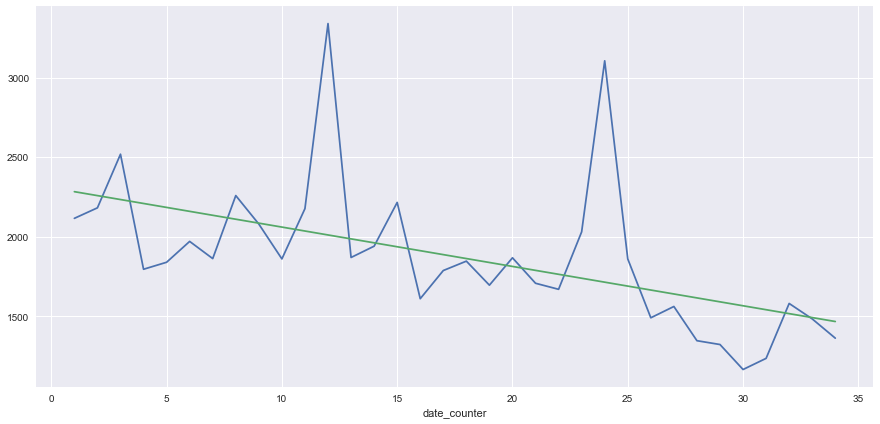

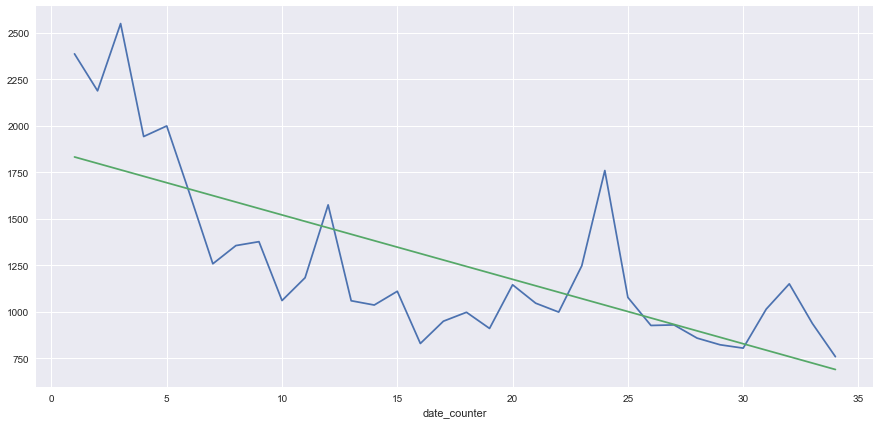

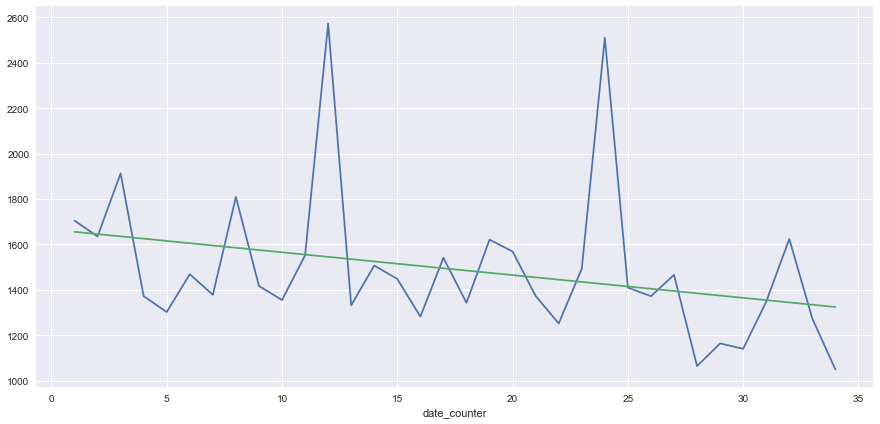

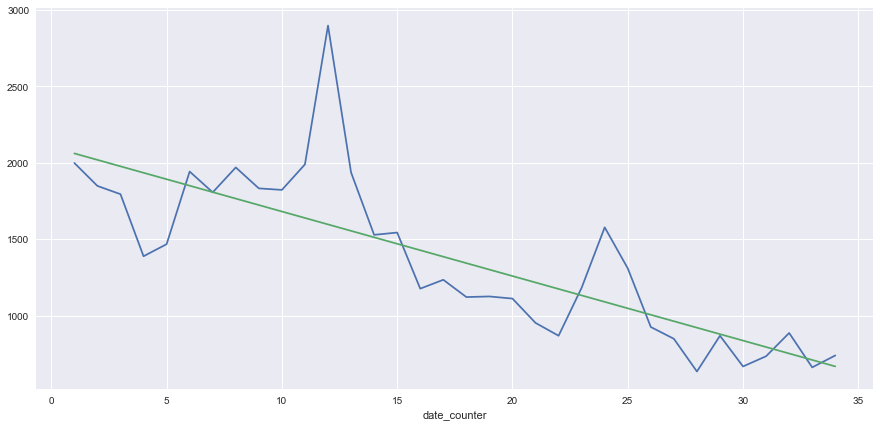

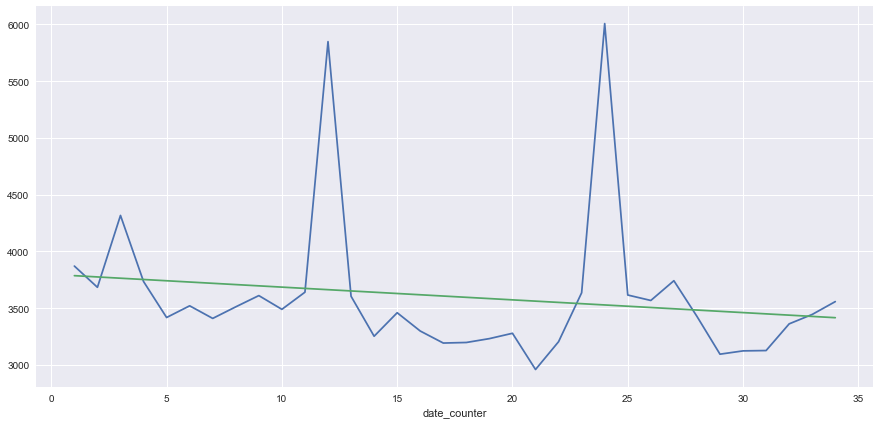

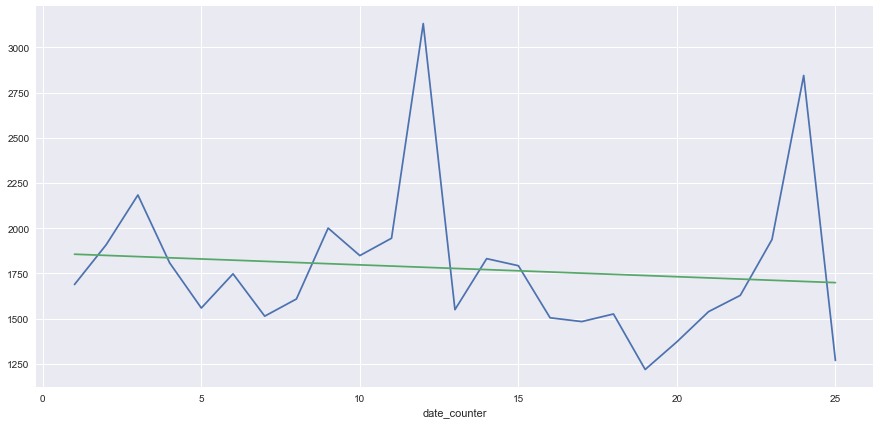

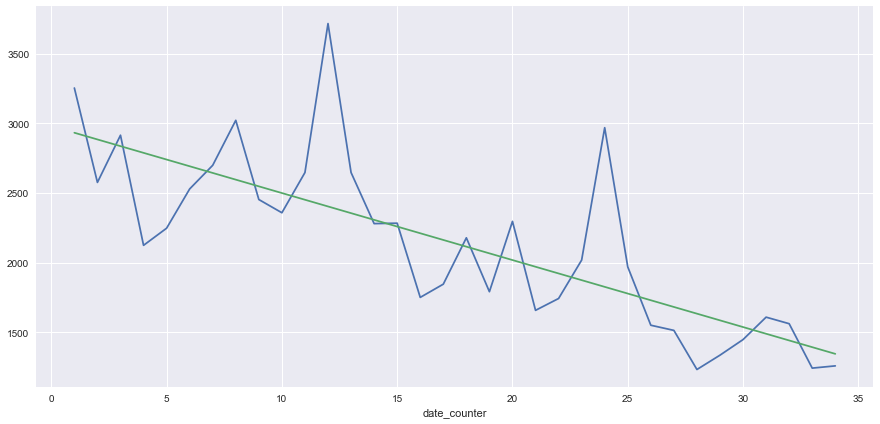

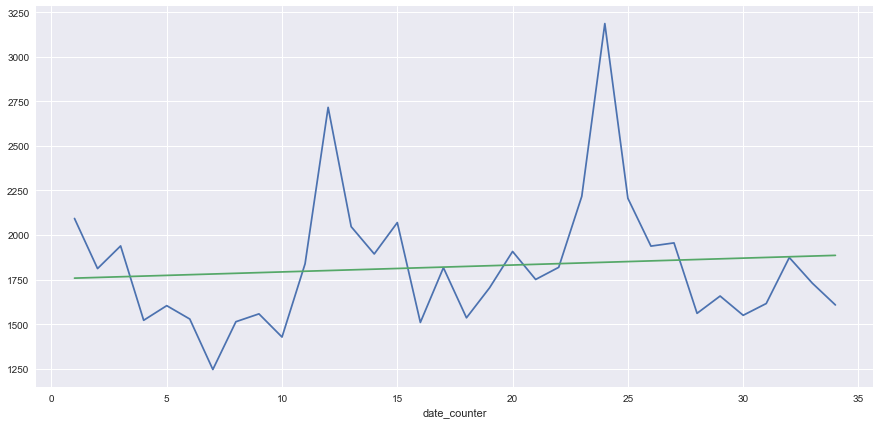

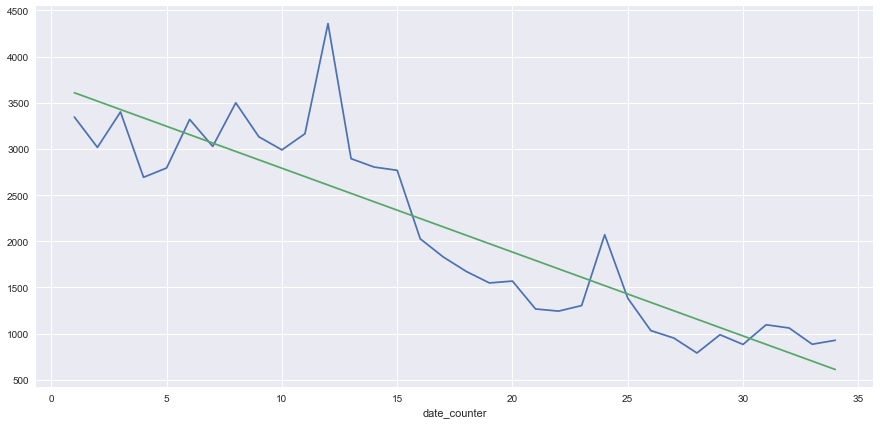

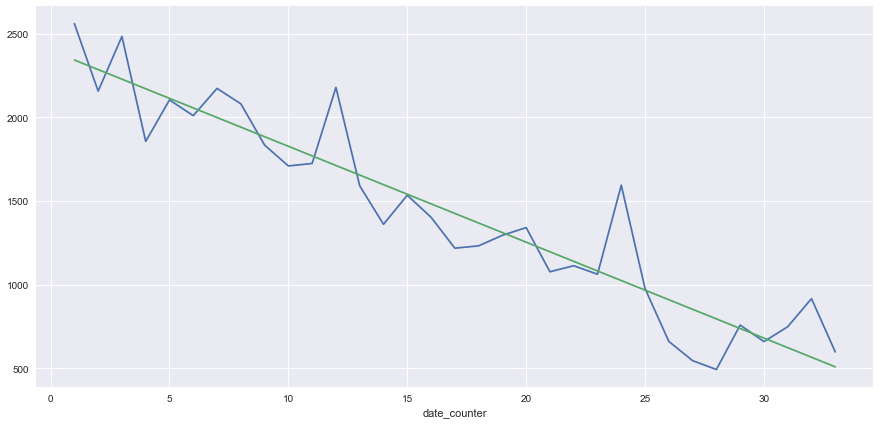

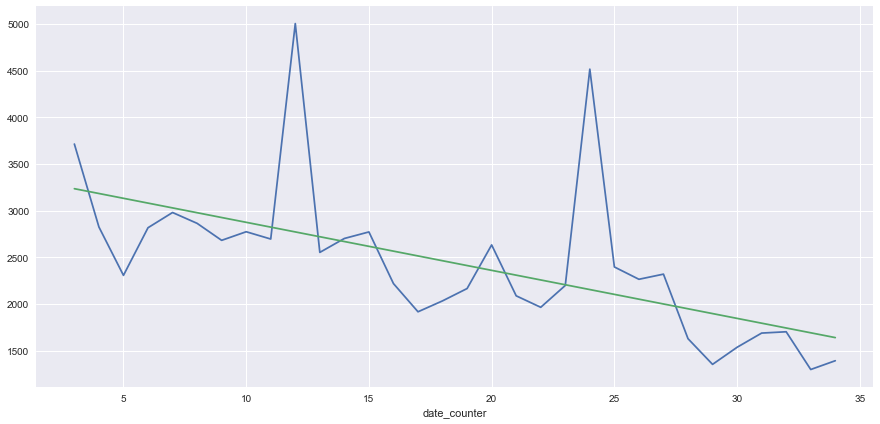

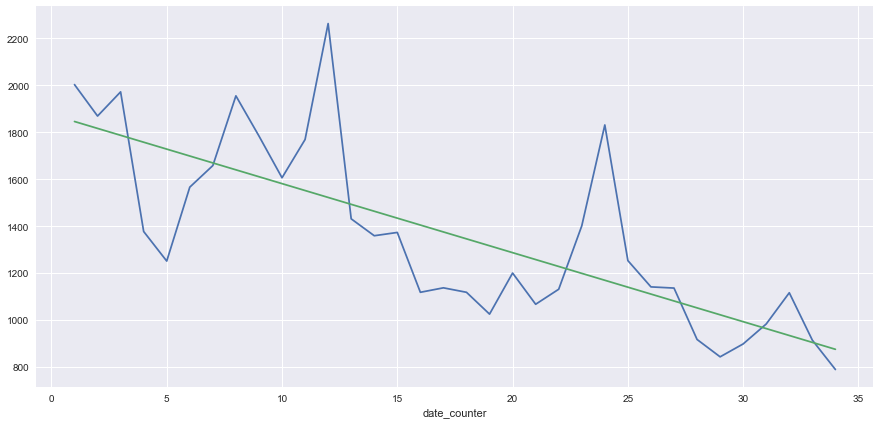

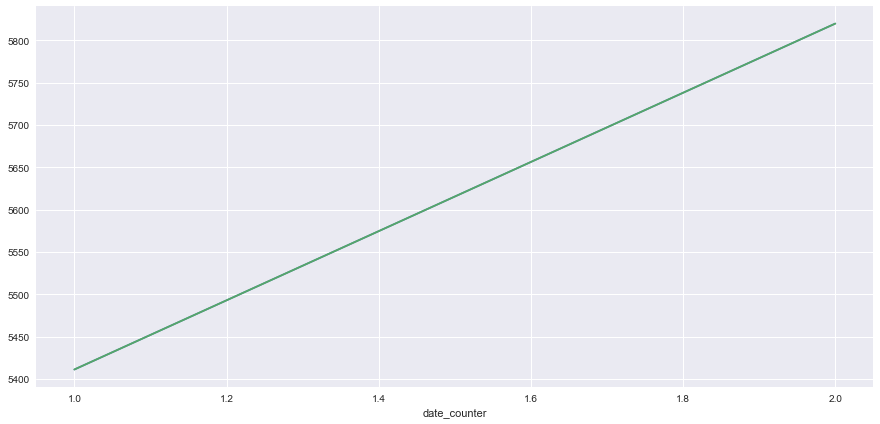

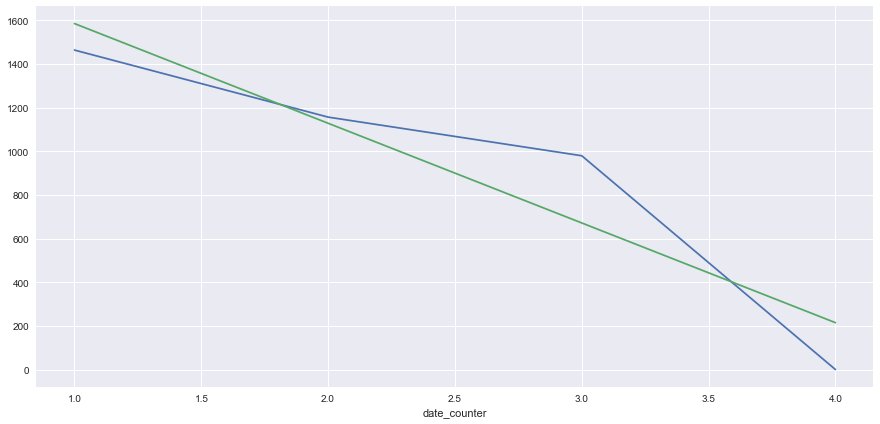

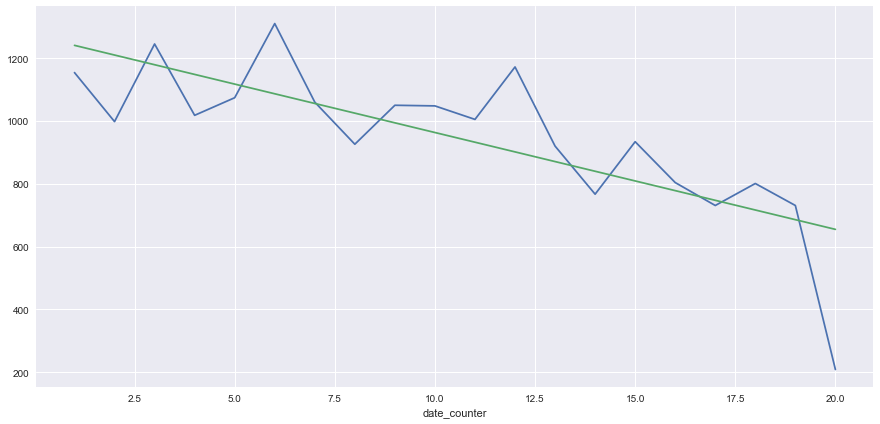

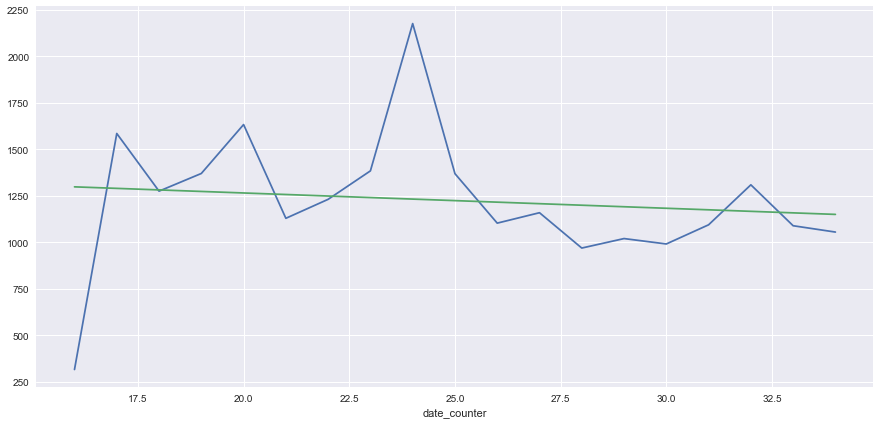

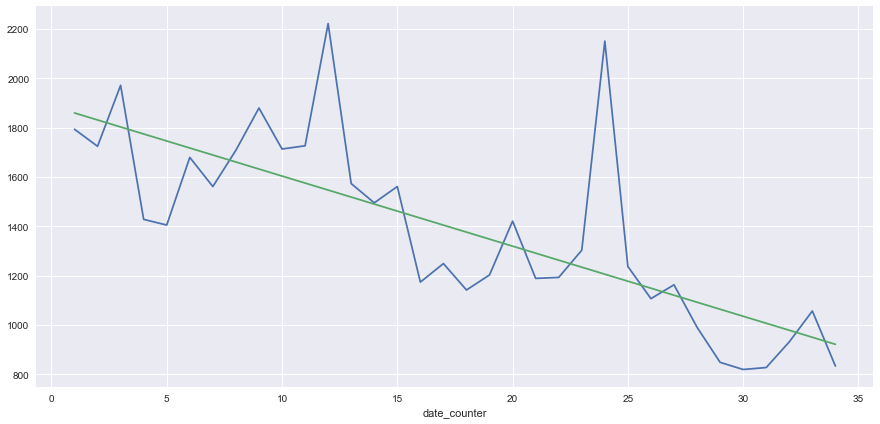

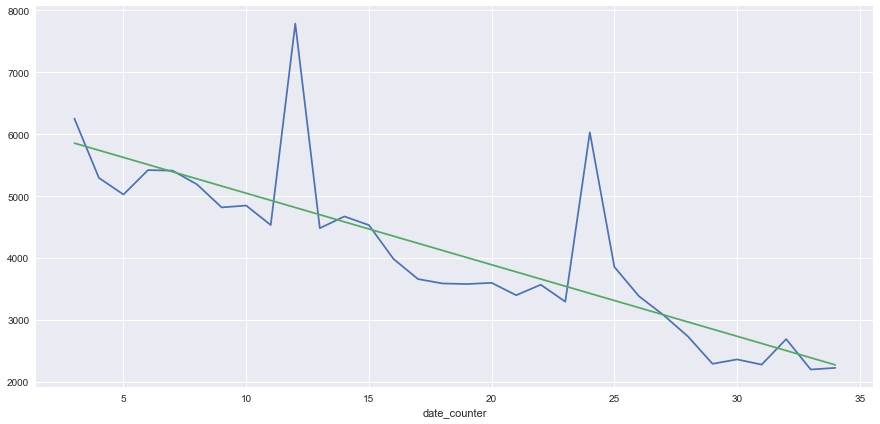

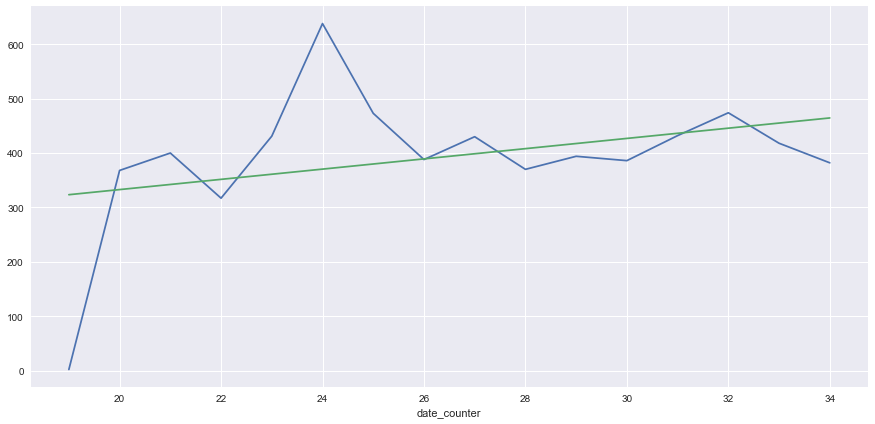

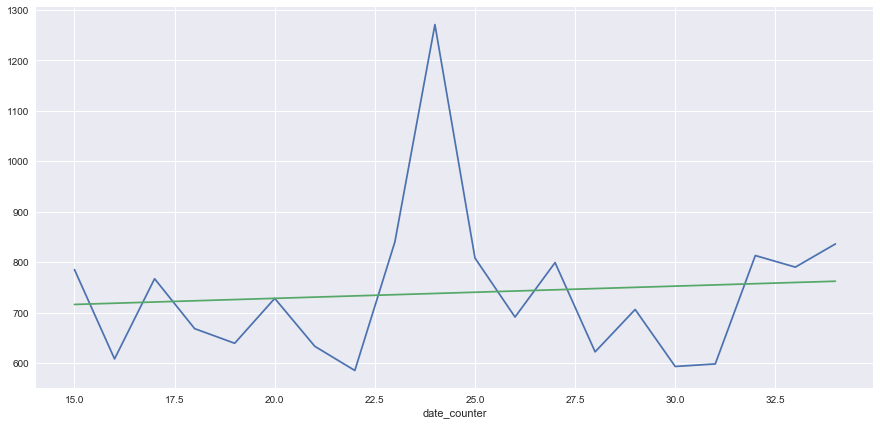

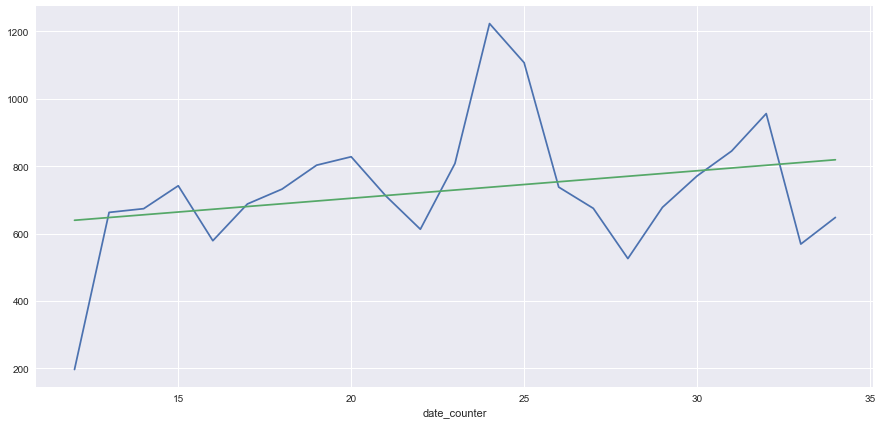

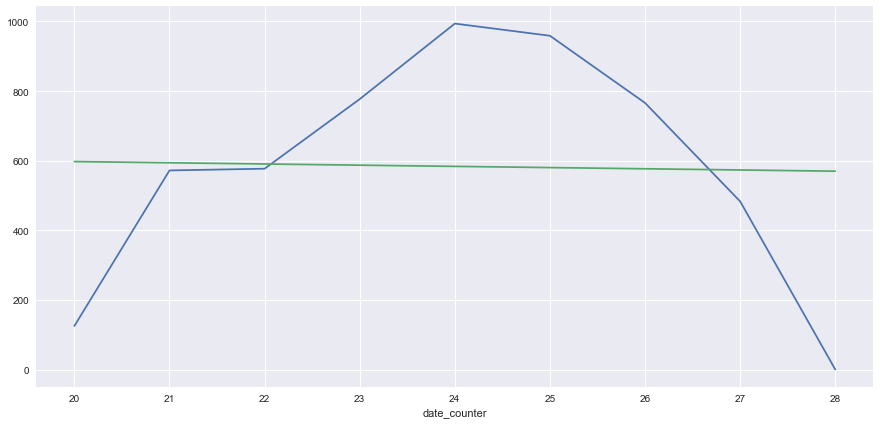

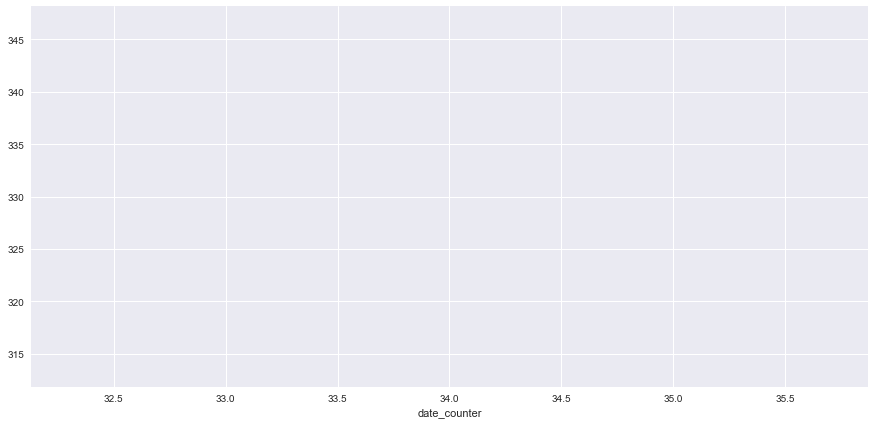

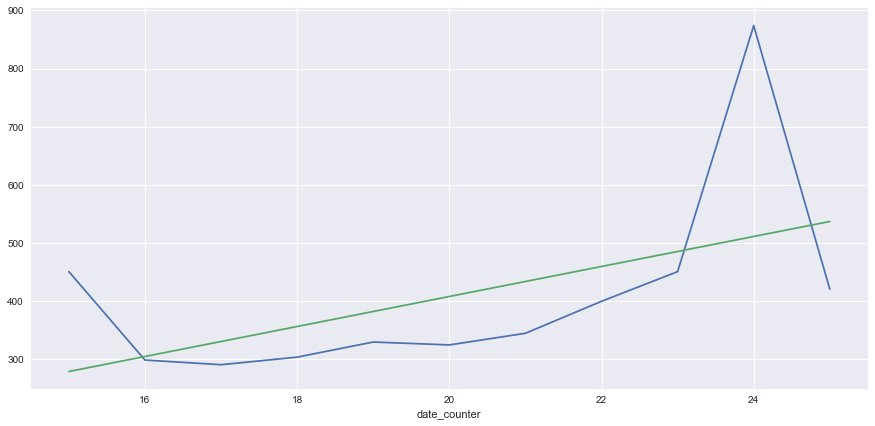

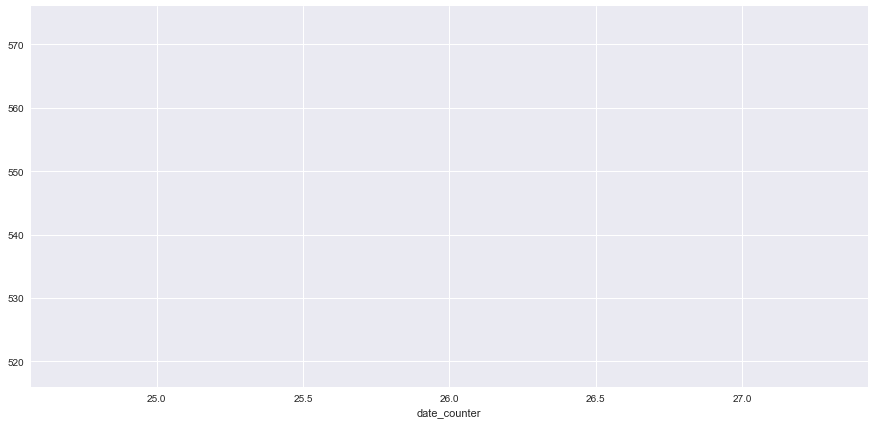

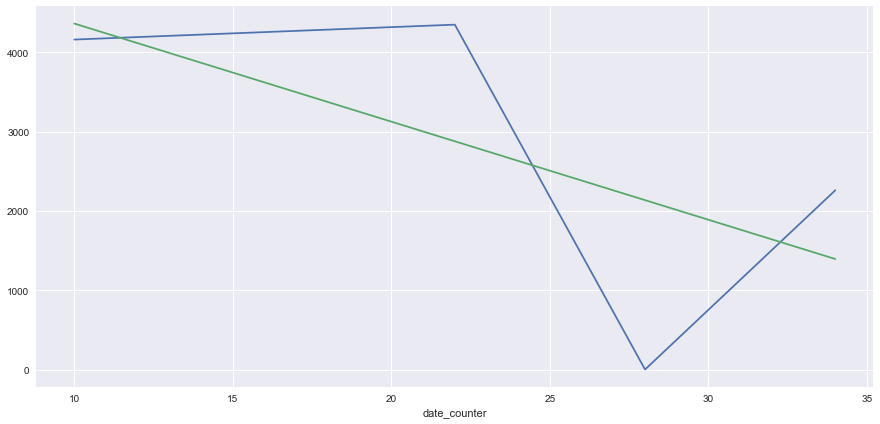

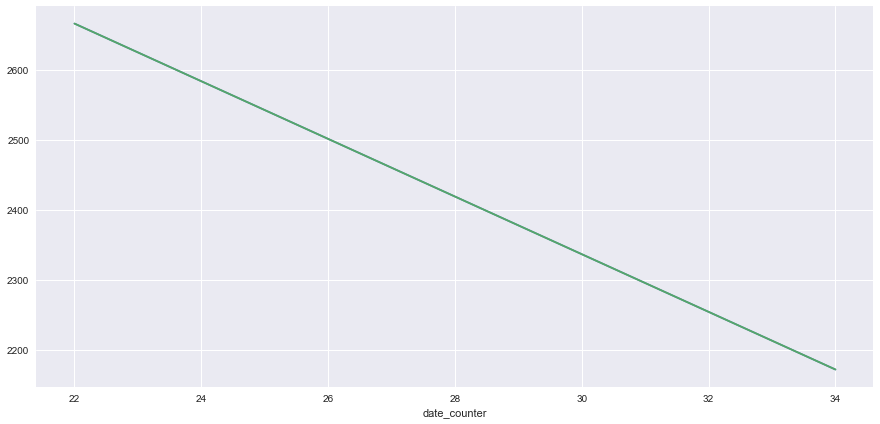

In [205]:
shop_ids = w_cat_ids.shop_id.unique()

for shop_id in shop_ids:
    get_coeffs_for_shop(shop_id, poly_degree=1, print_chart=True)

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RankWarning: Polyfit may be poorly conditioned


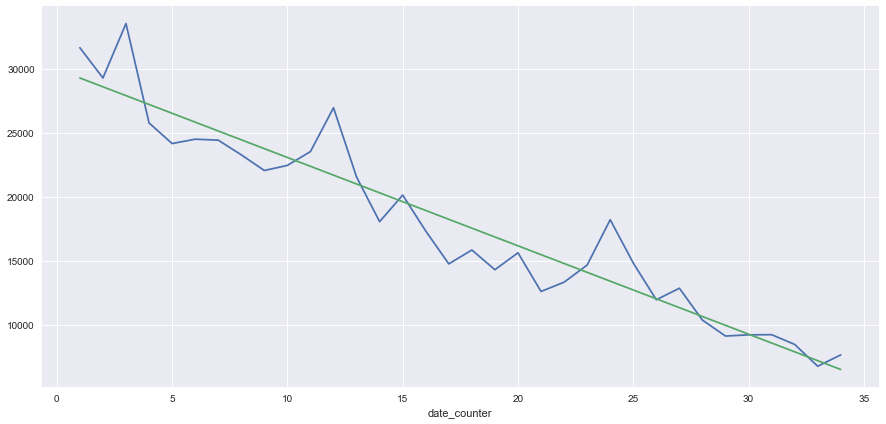

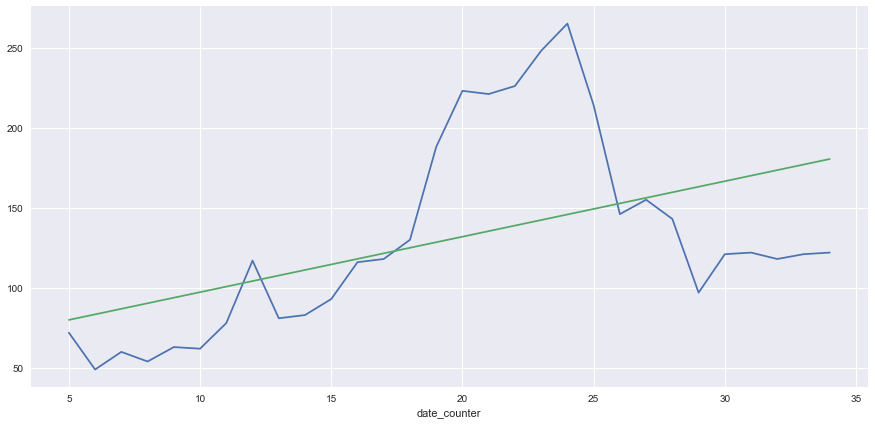

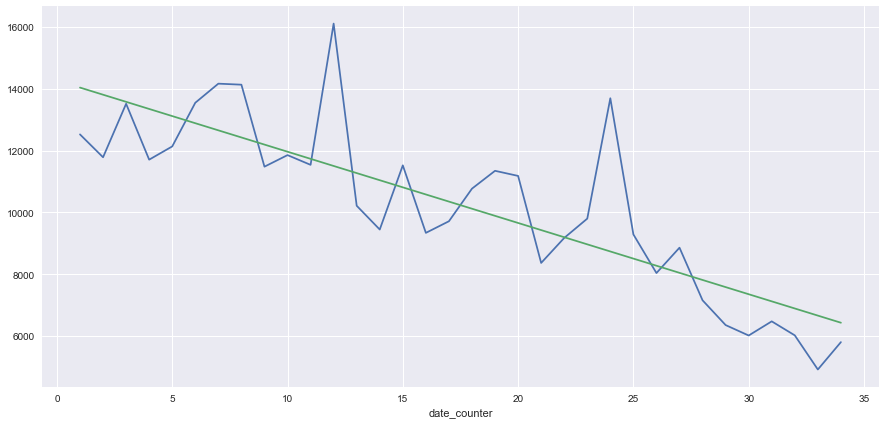

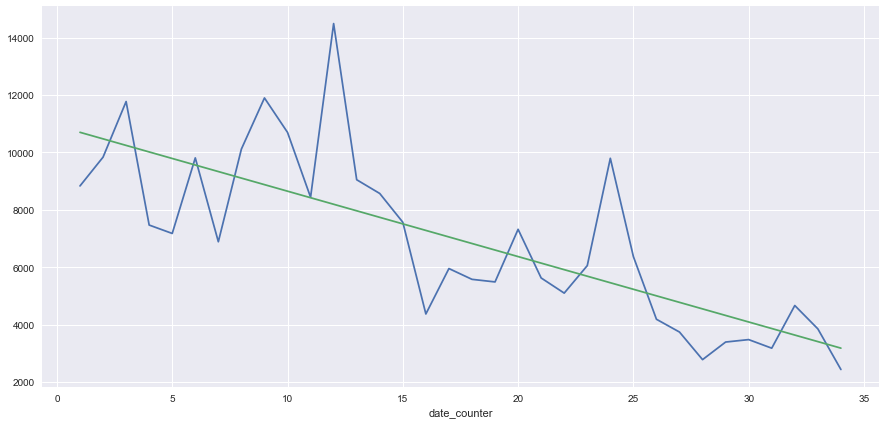

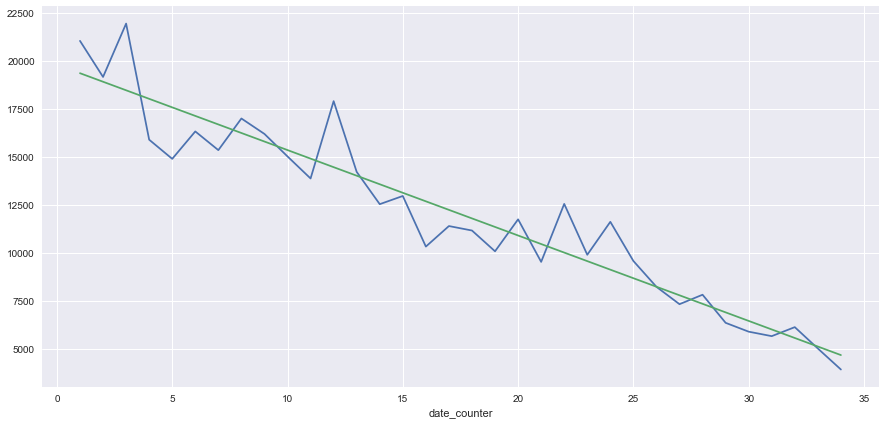

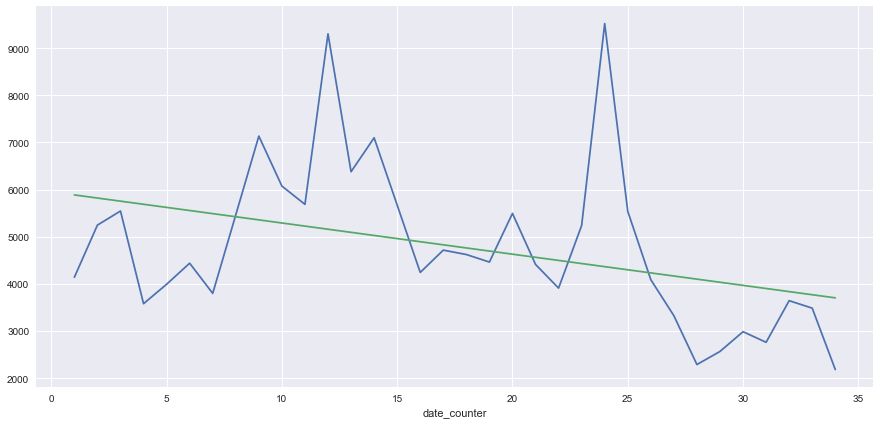

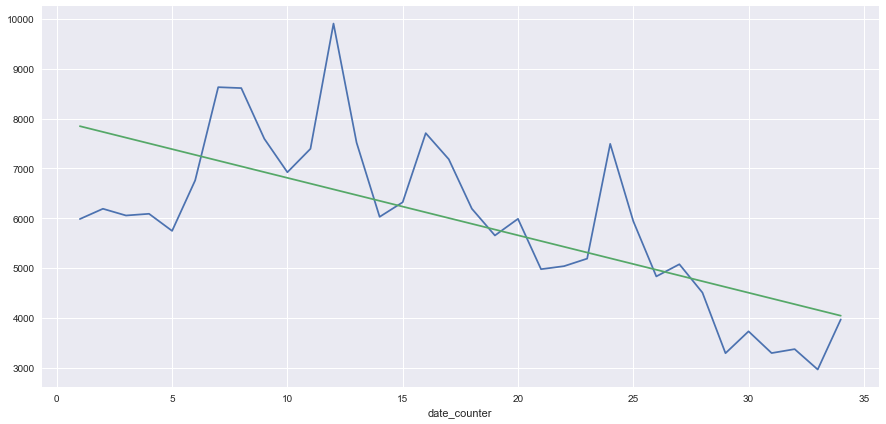

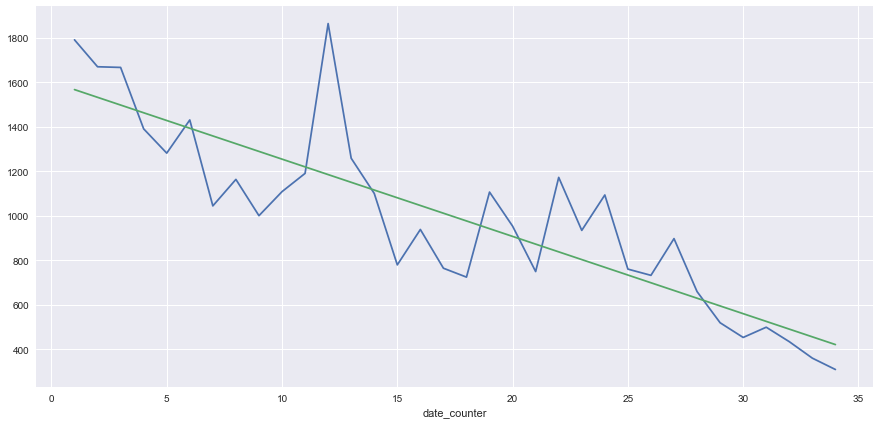

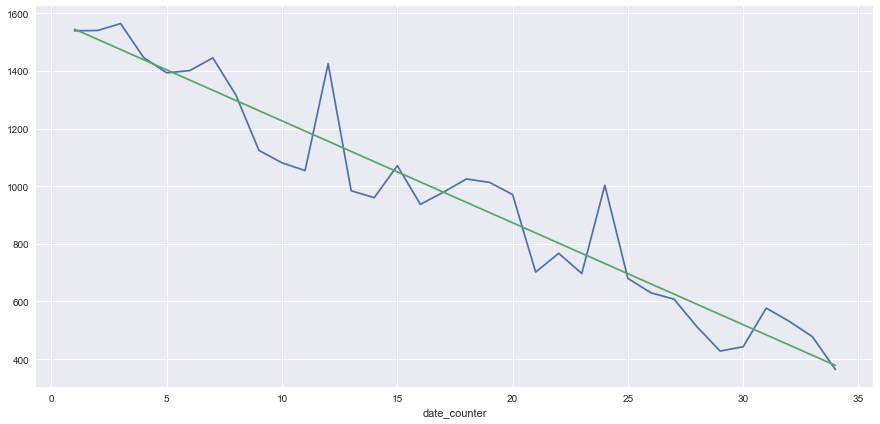

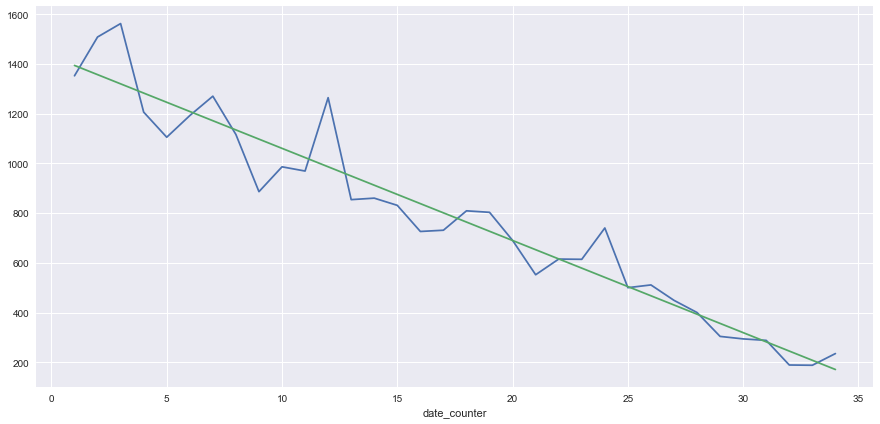

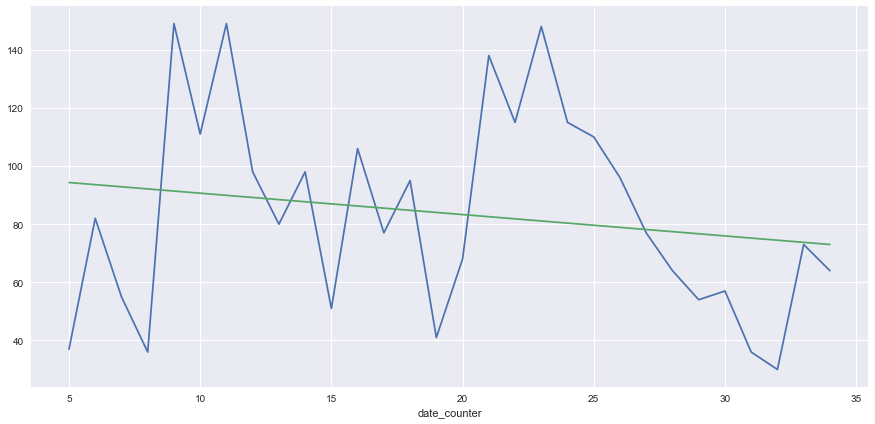

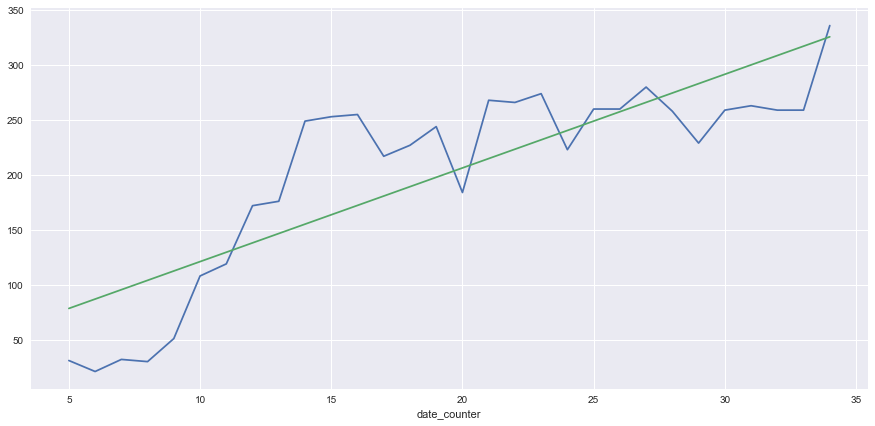

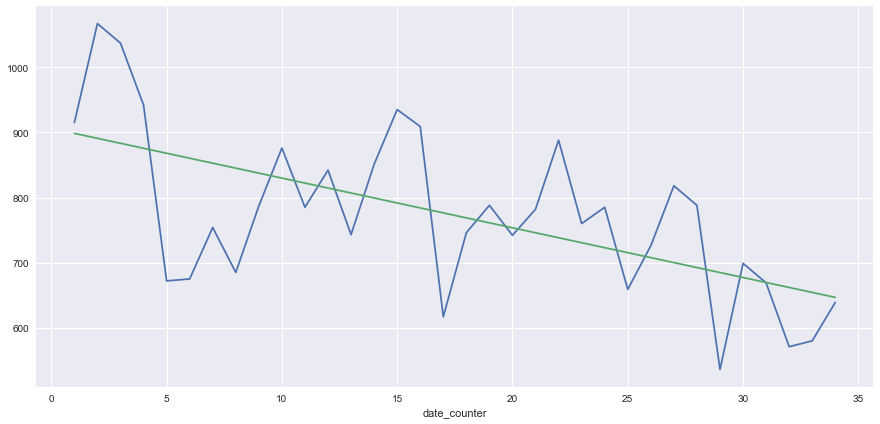

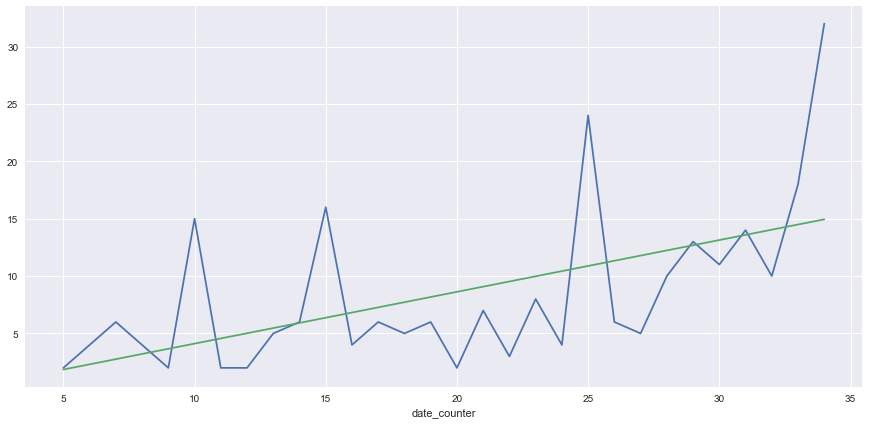

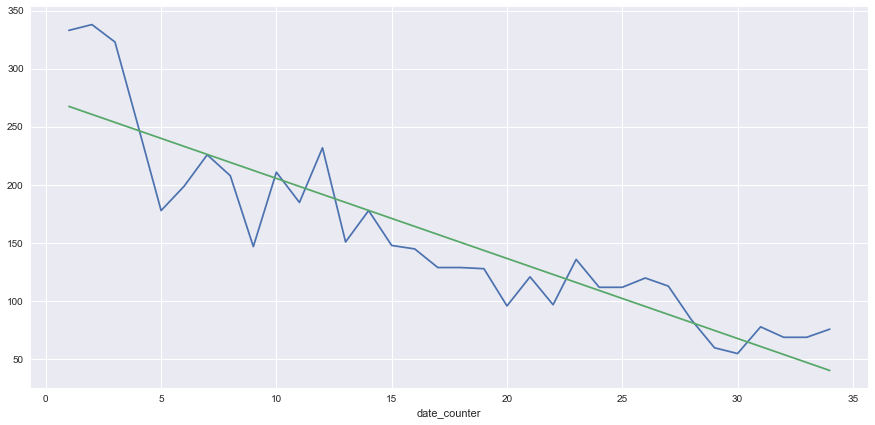

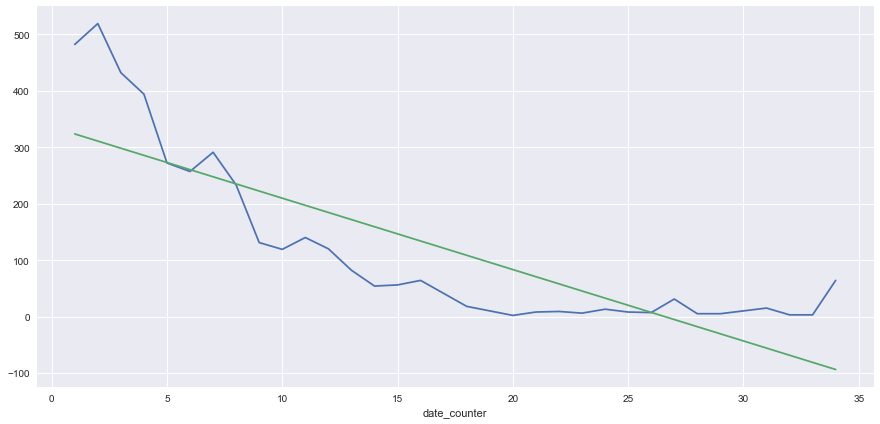

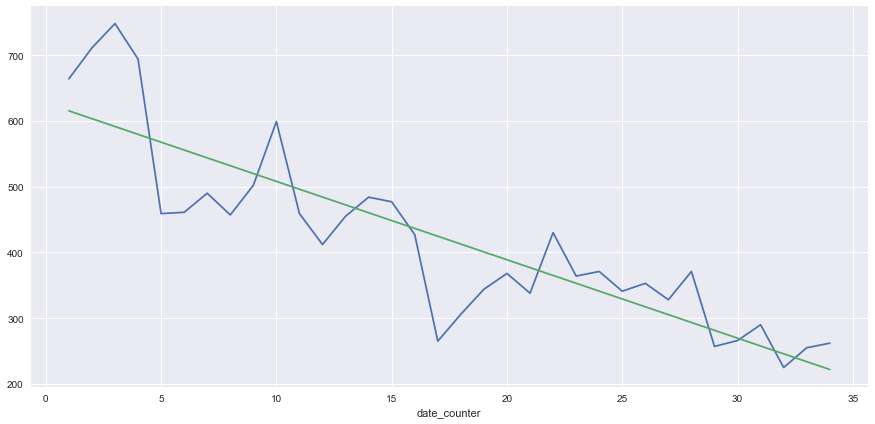

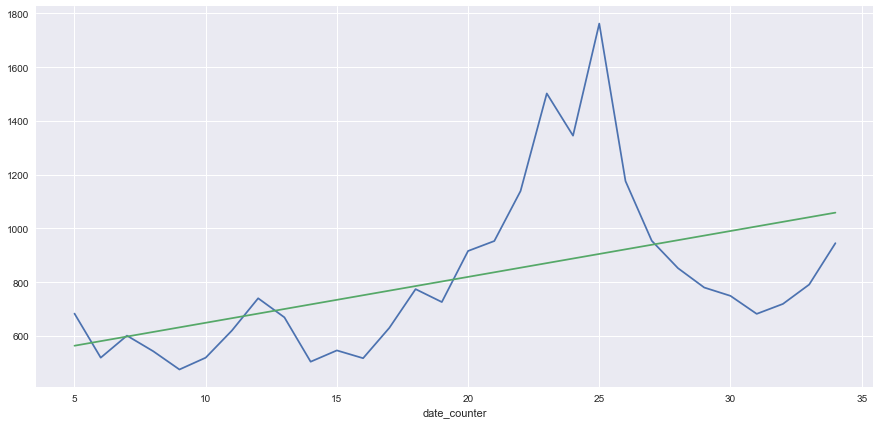

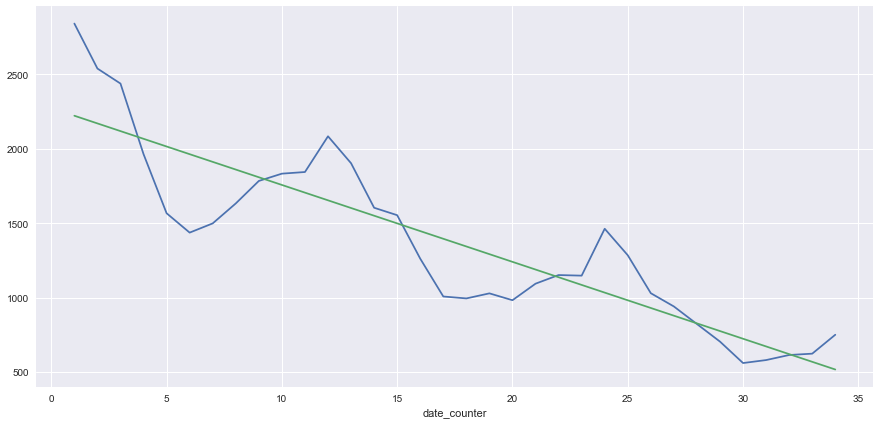

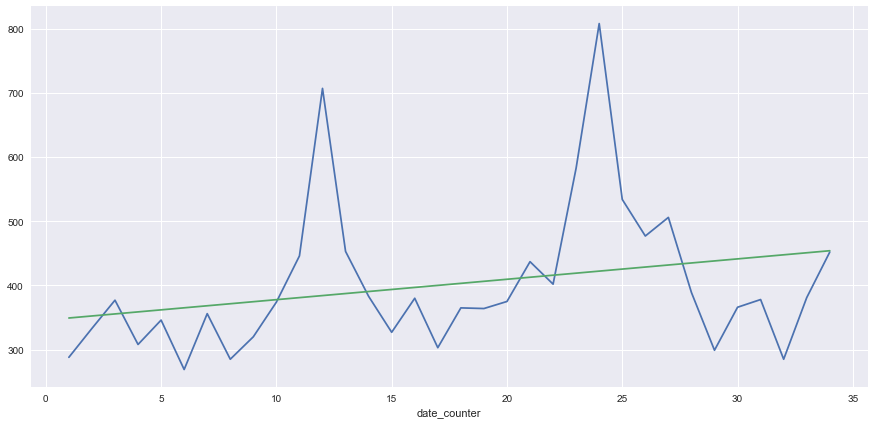

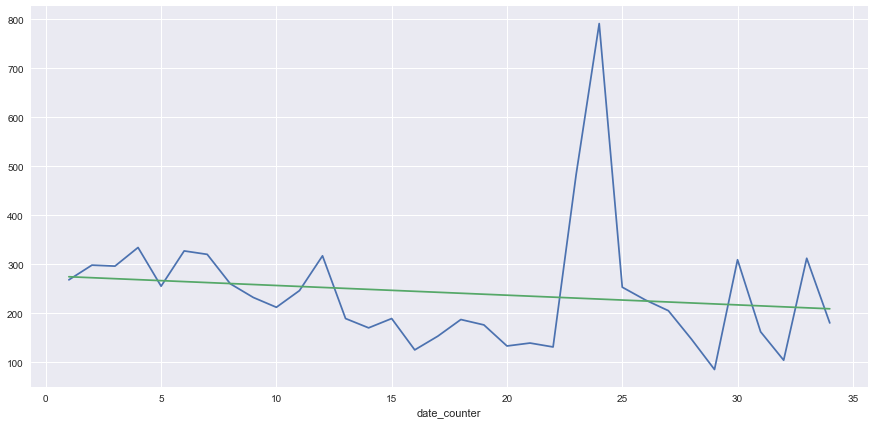

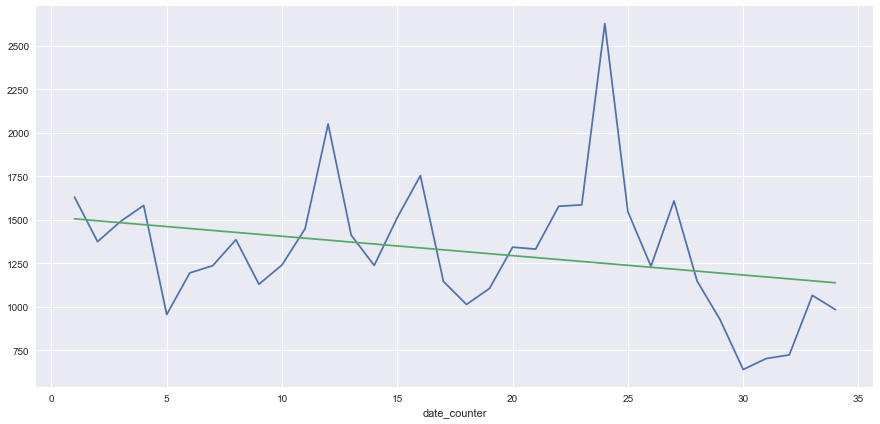

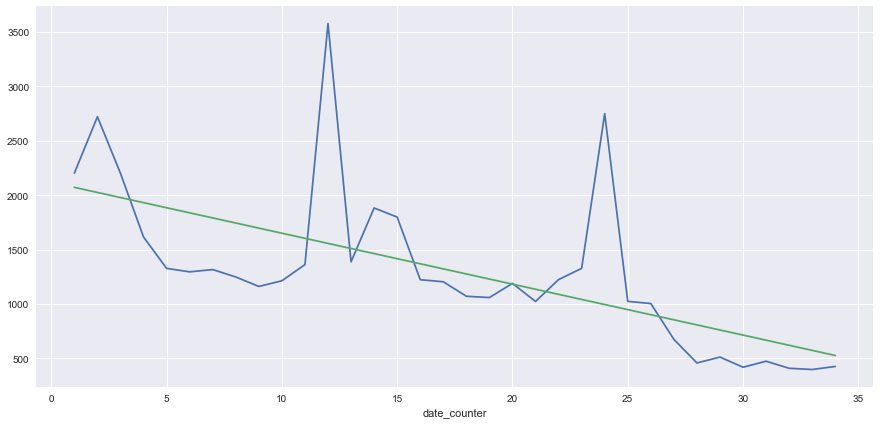

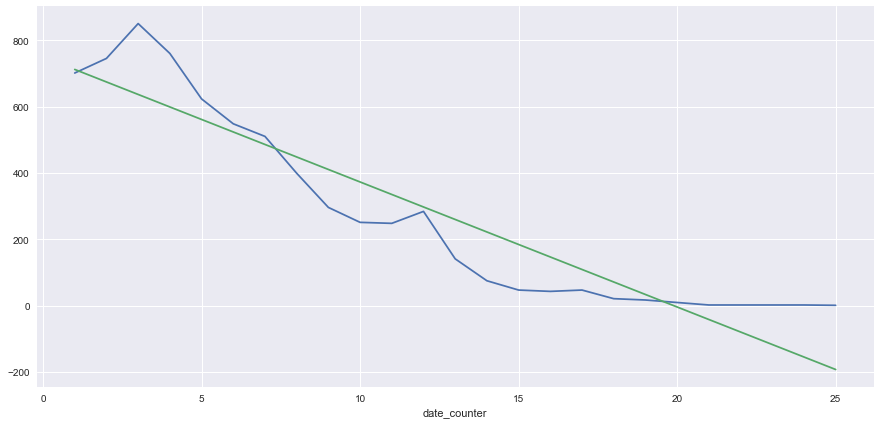

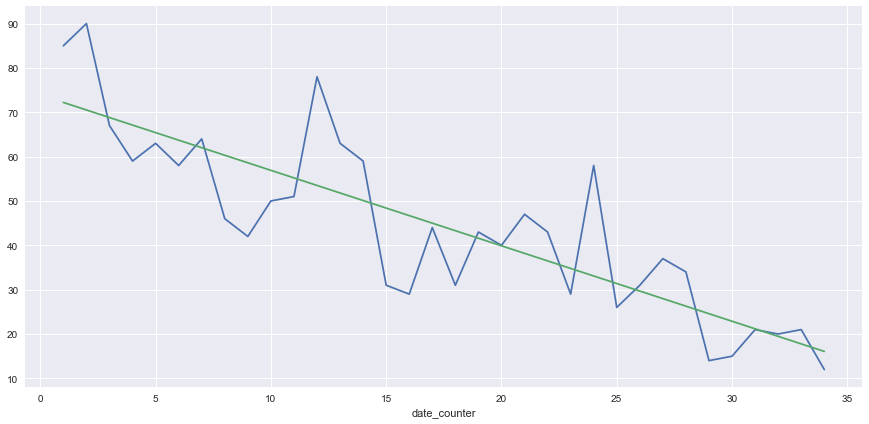

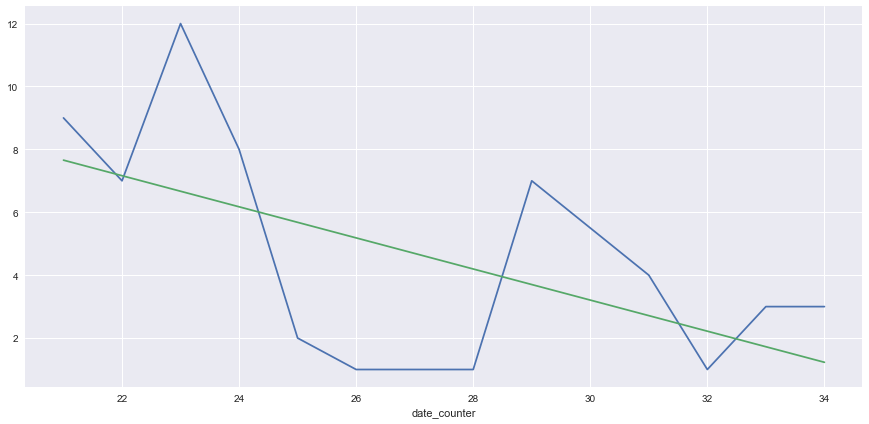

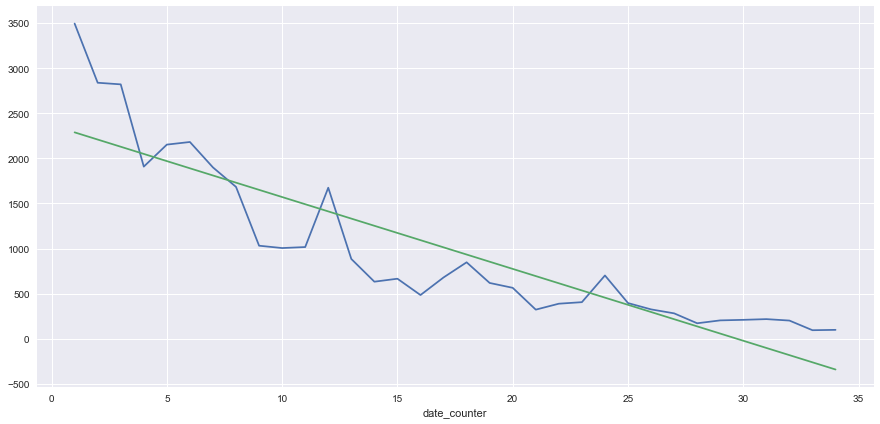

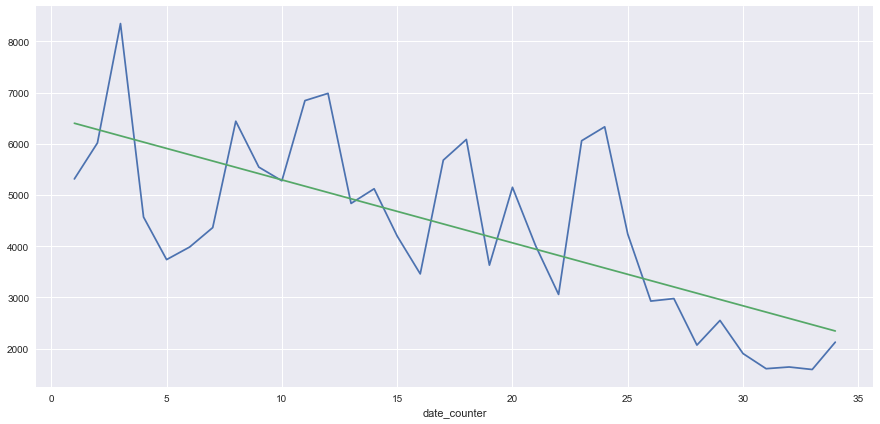

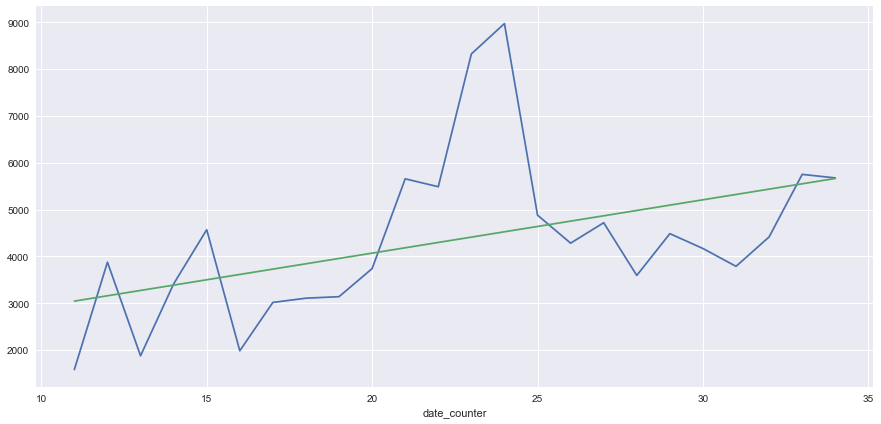

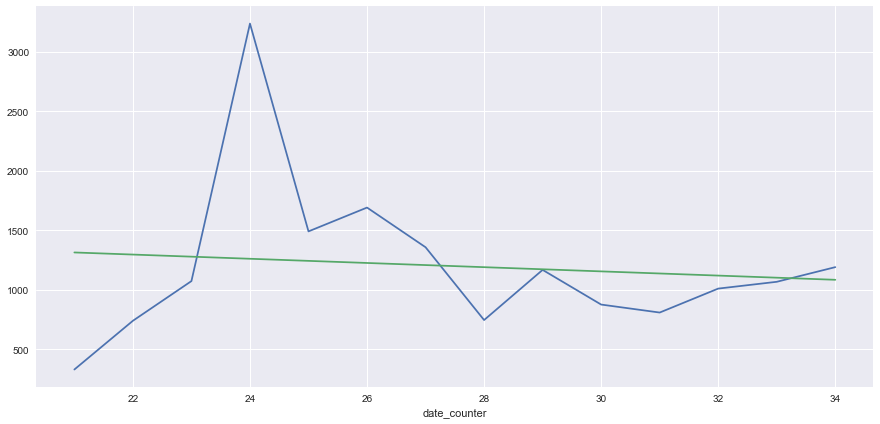

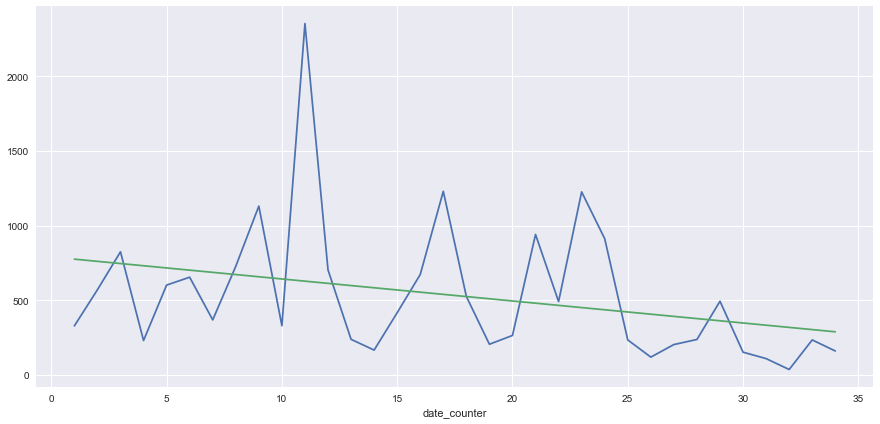

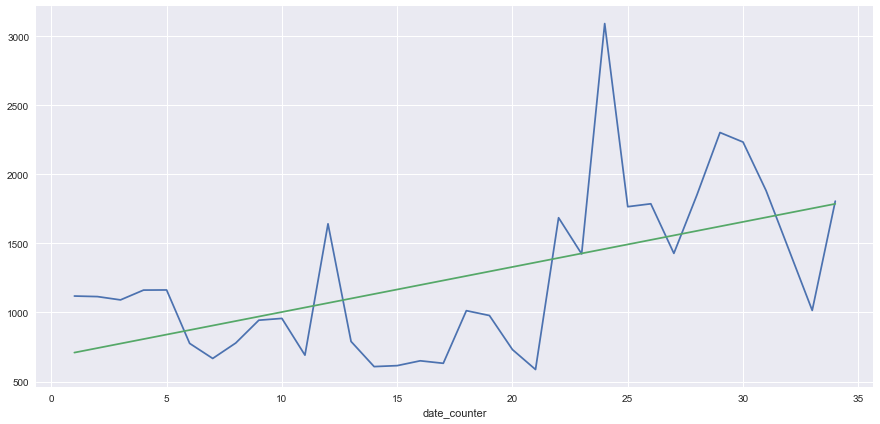

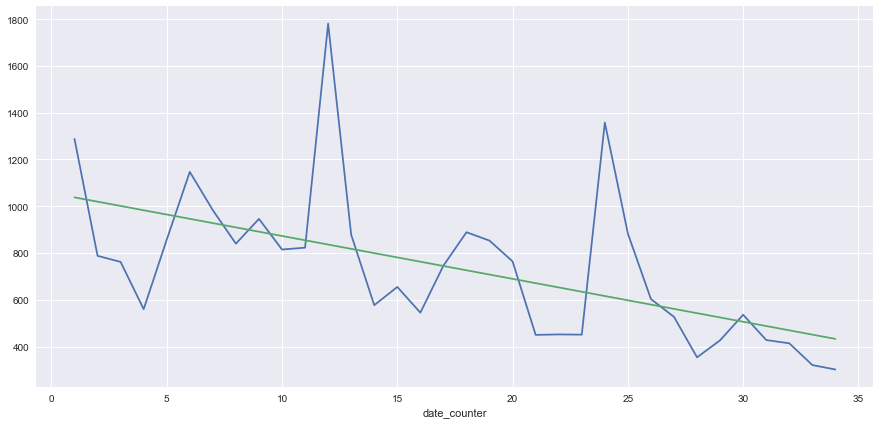

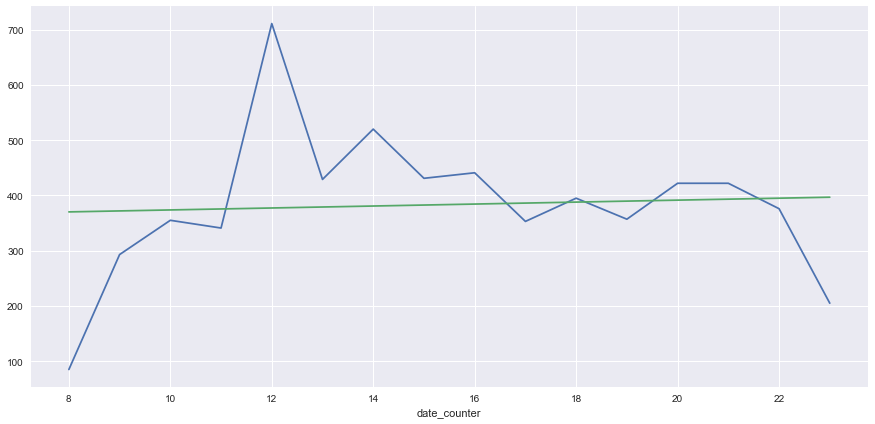

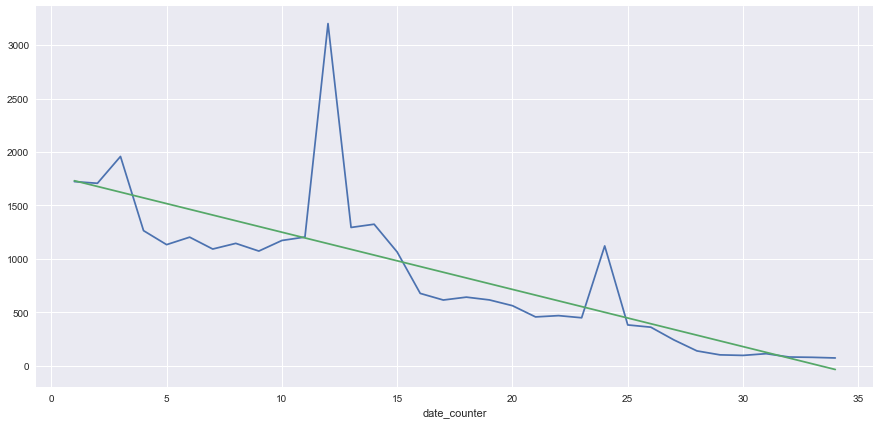

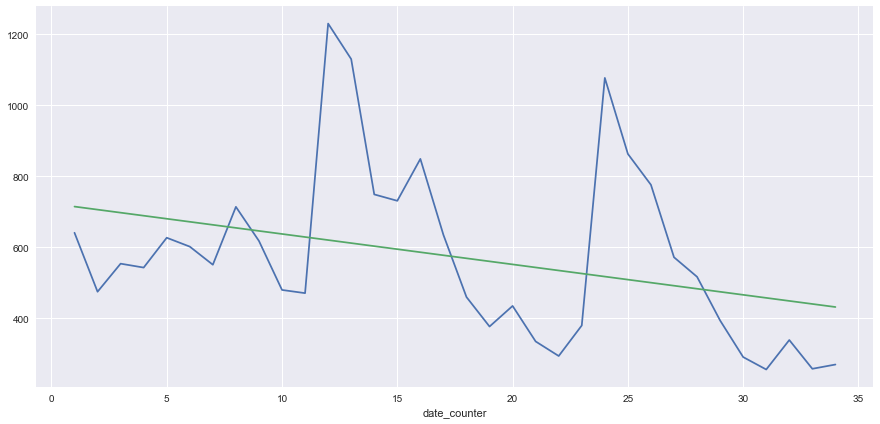

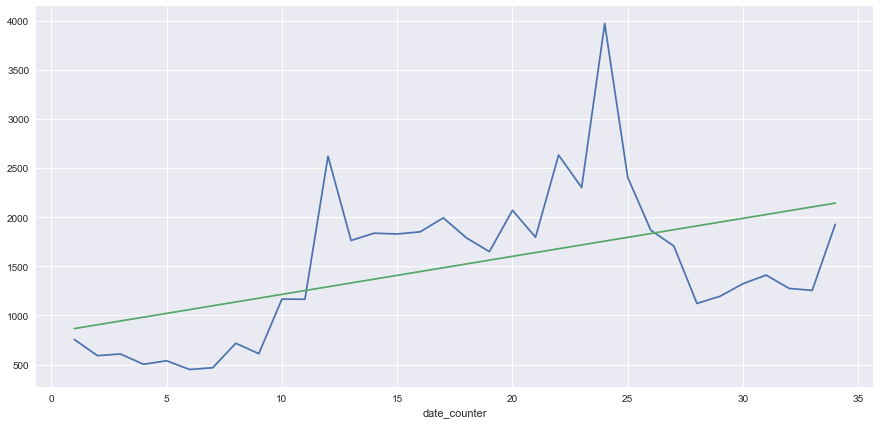

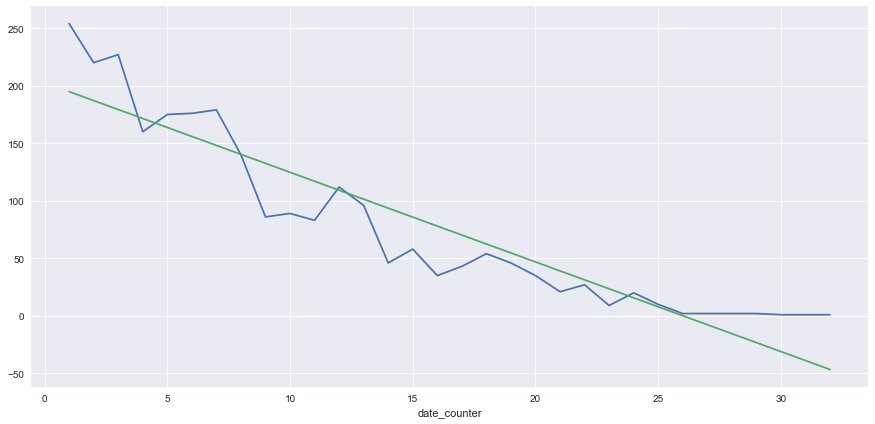

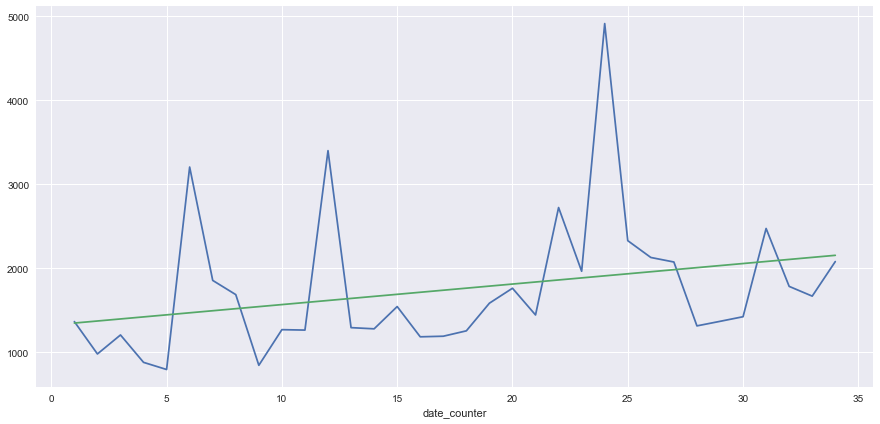

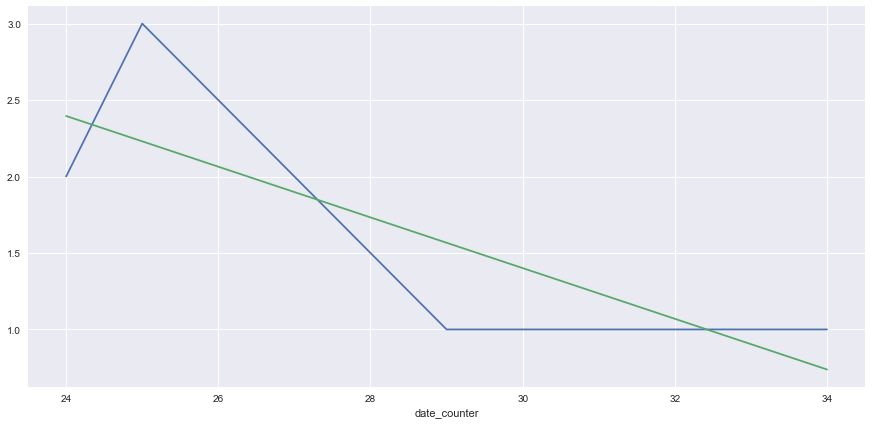

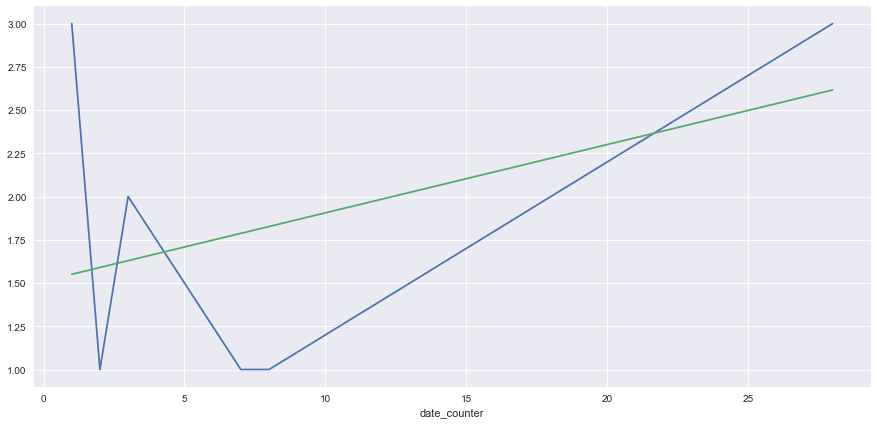

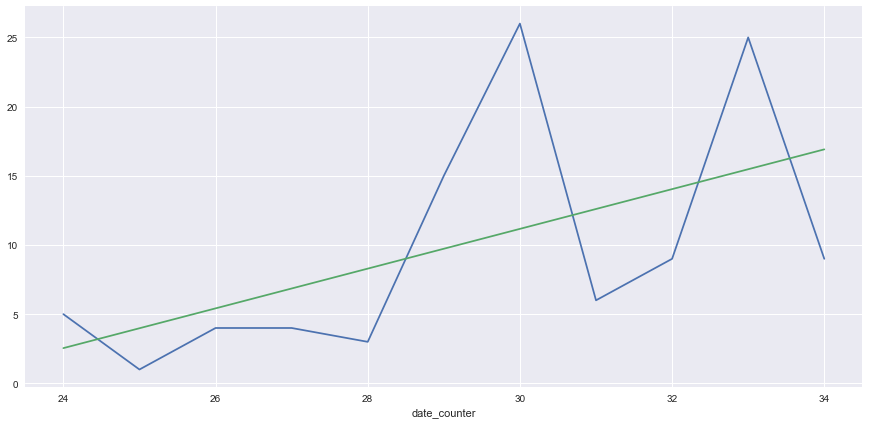

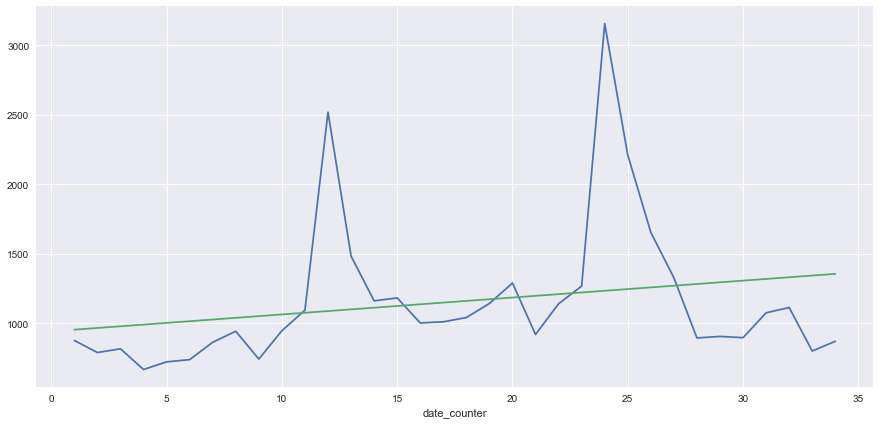

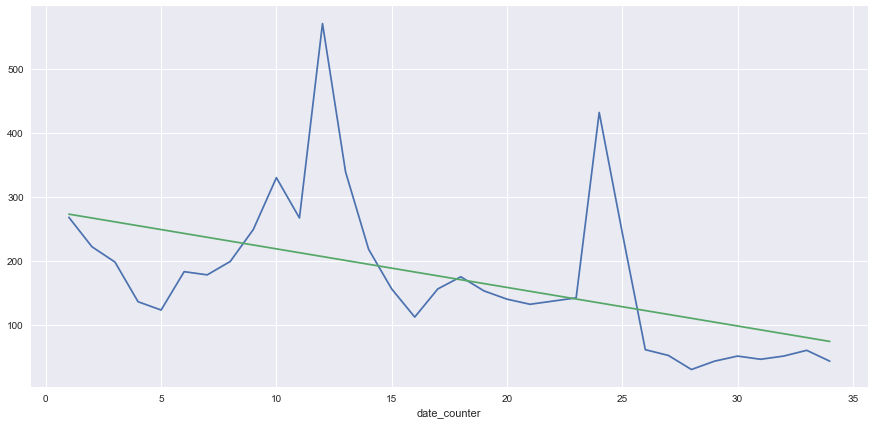

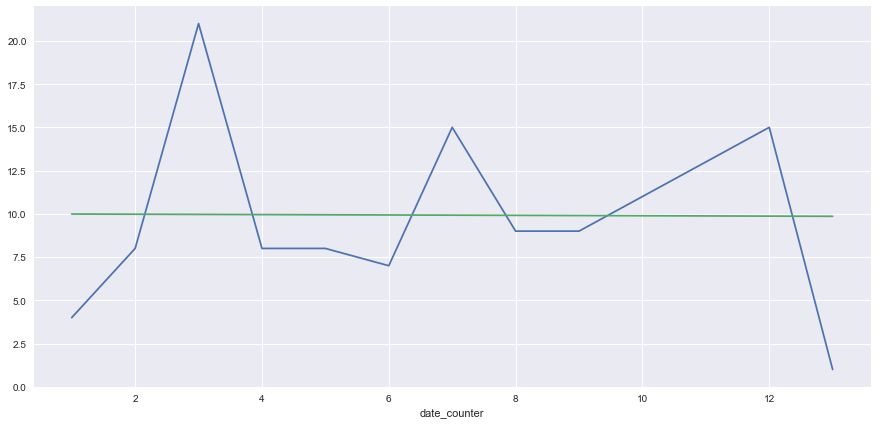

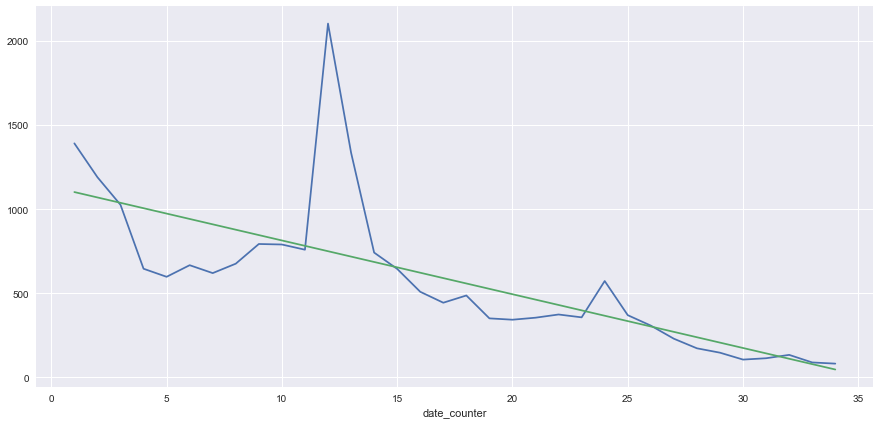

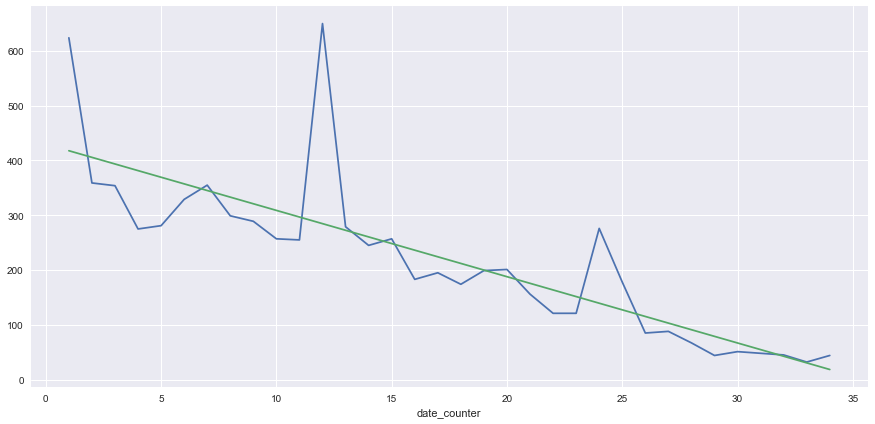

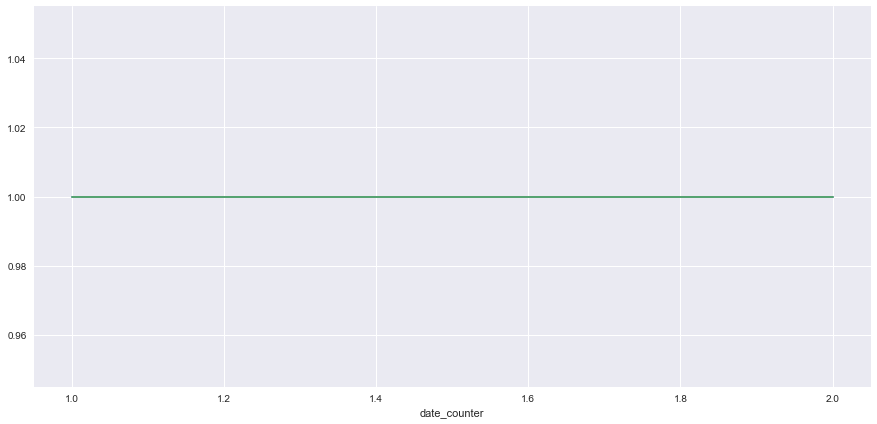

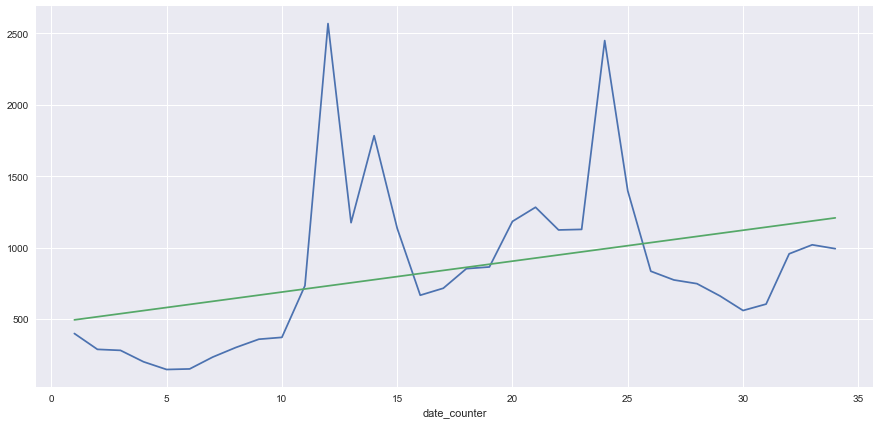

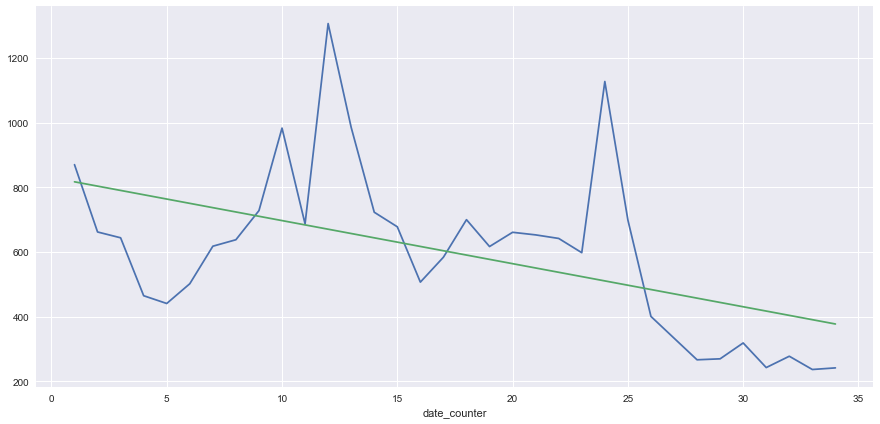

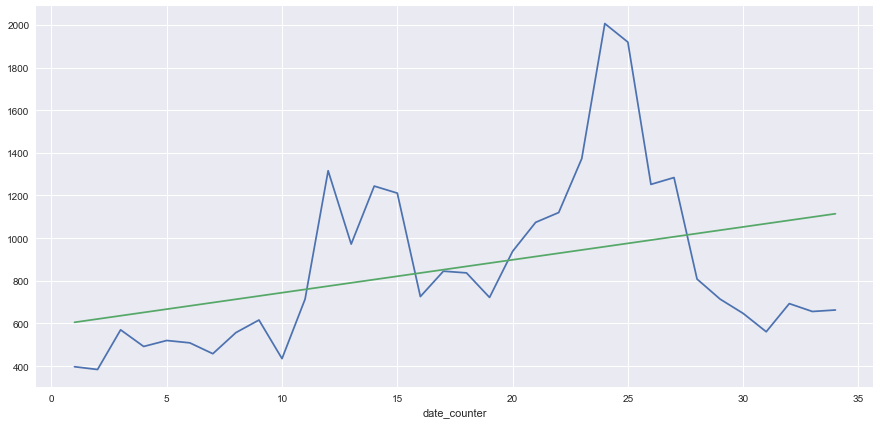

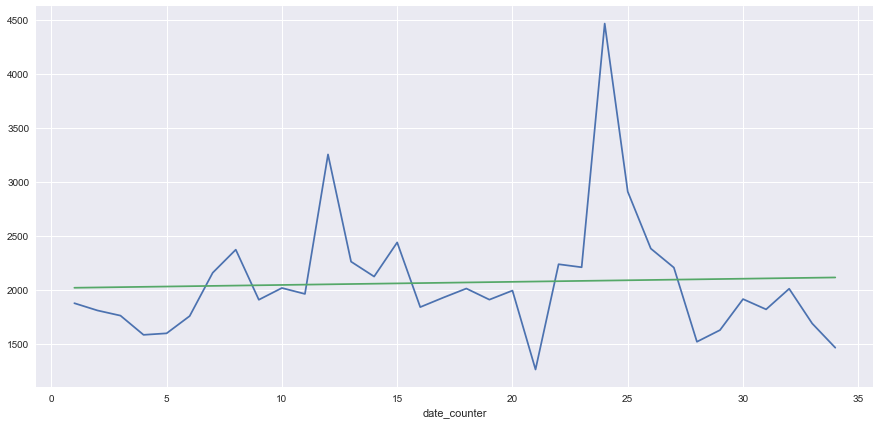

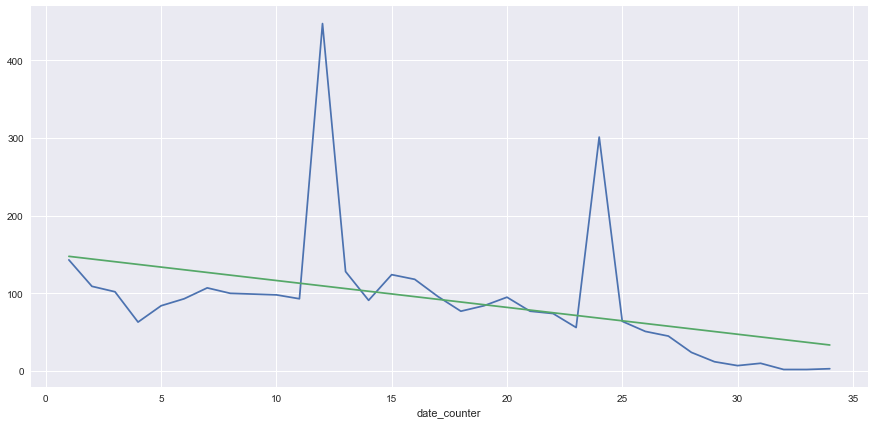

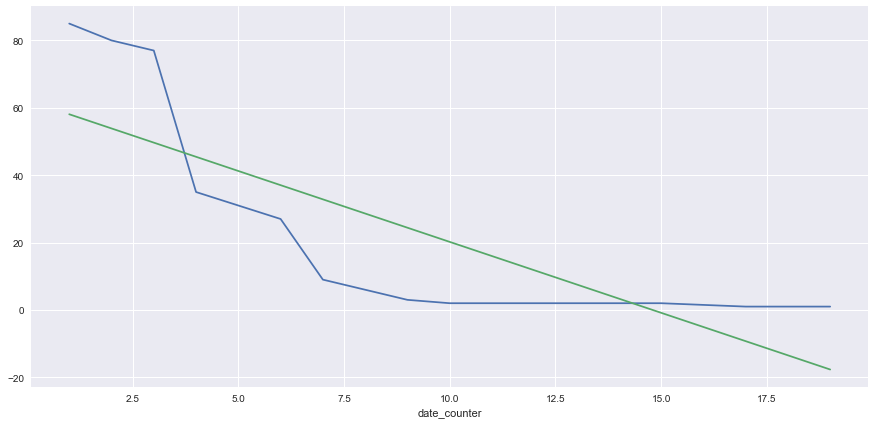

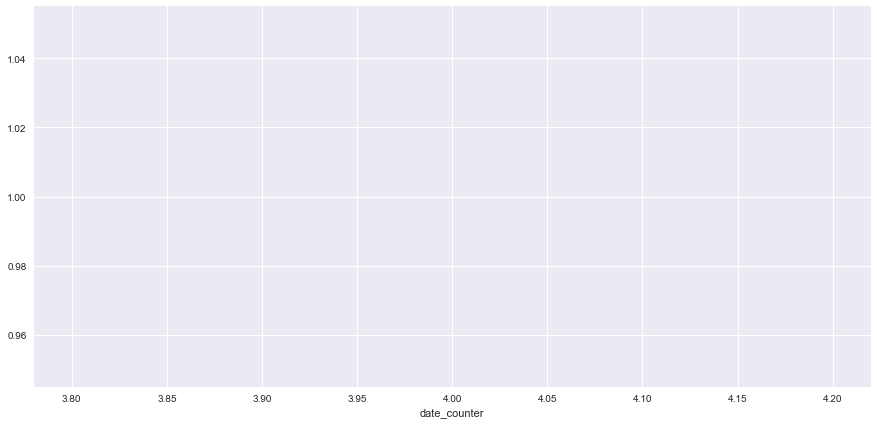

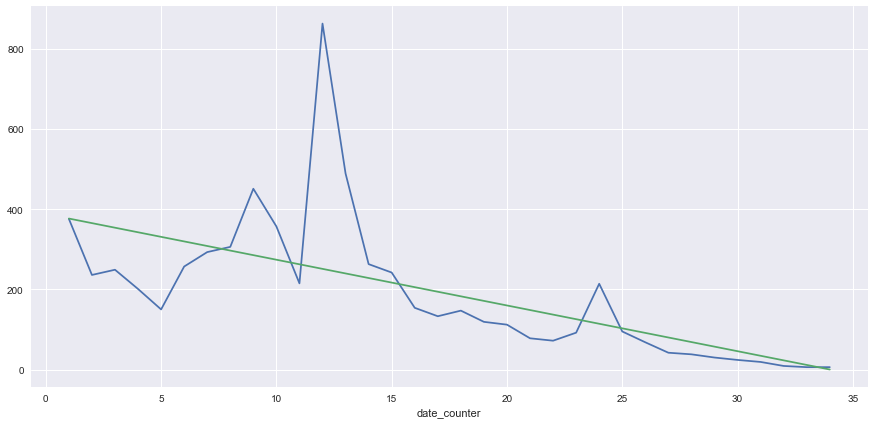

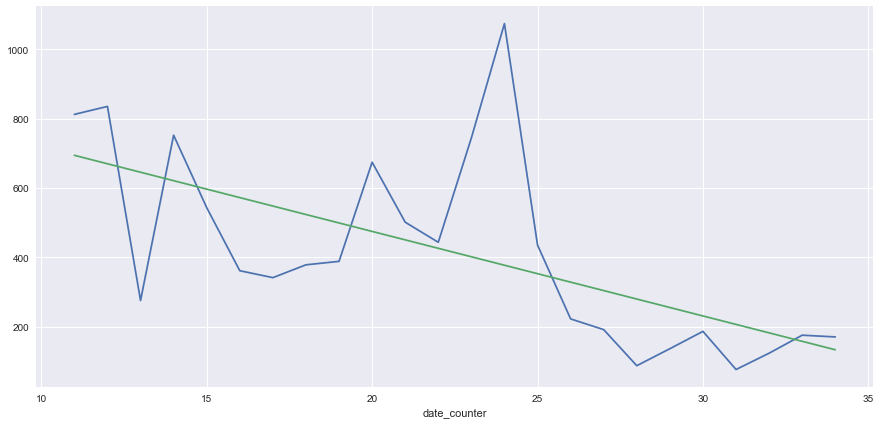

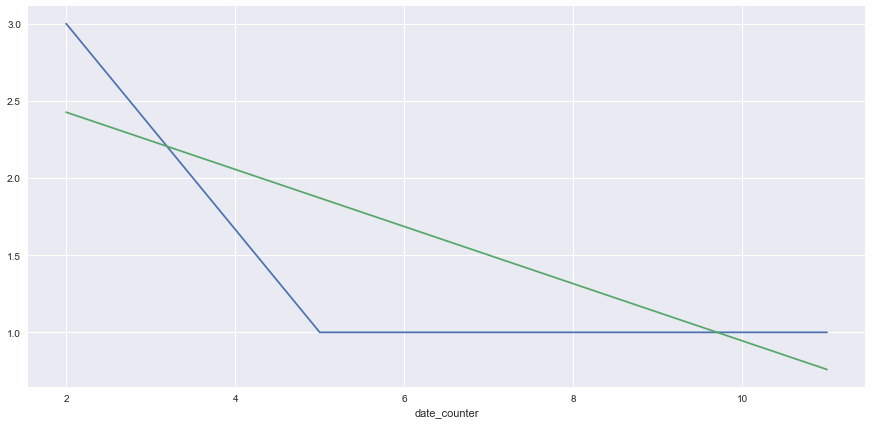

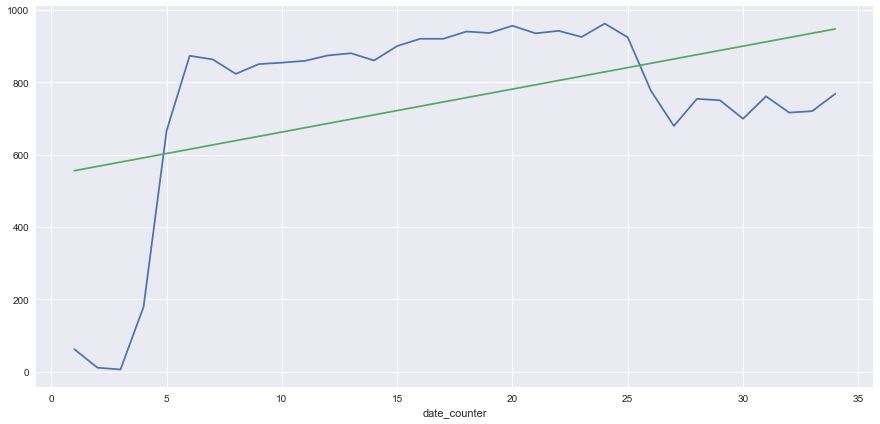

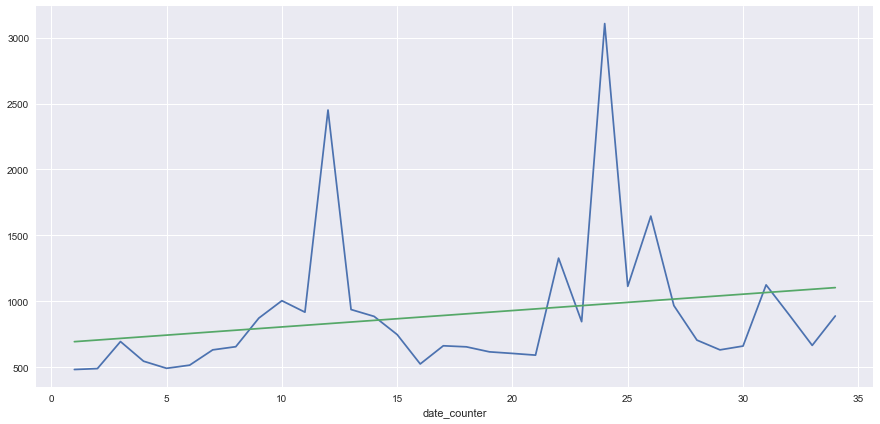

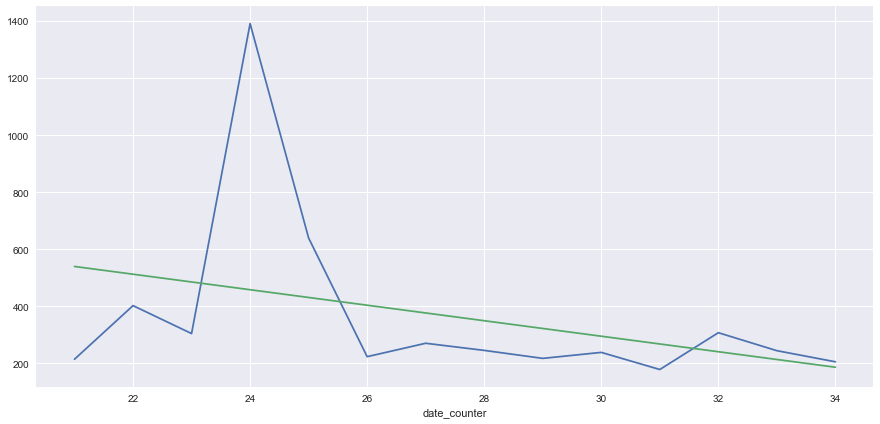

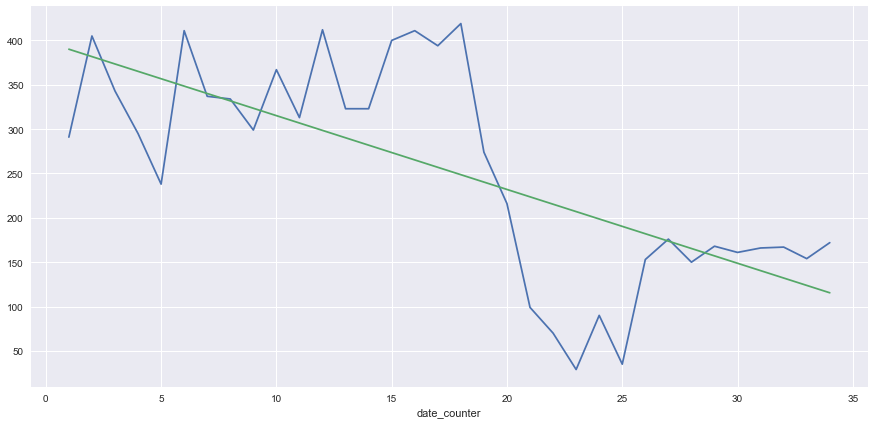

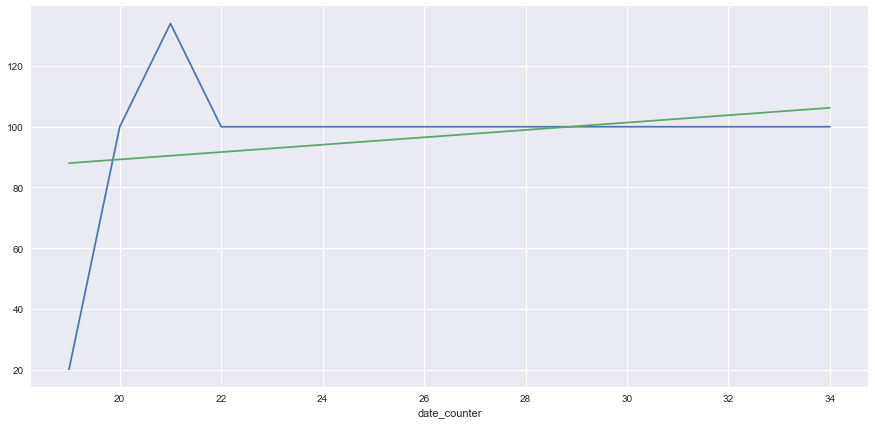

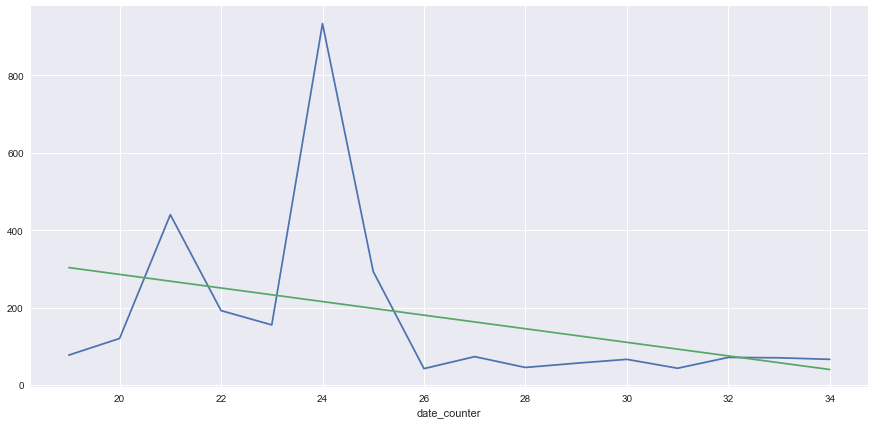

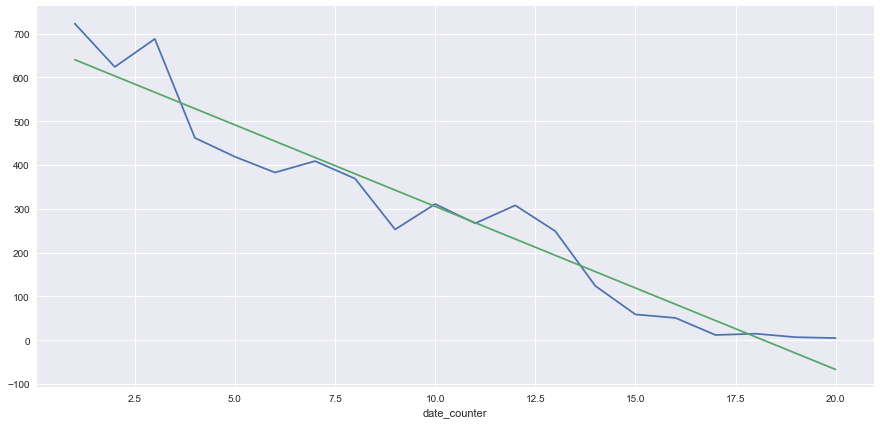

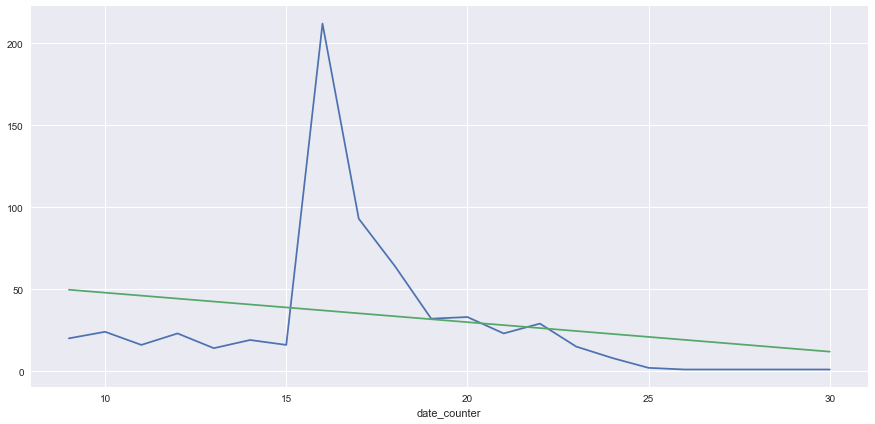

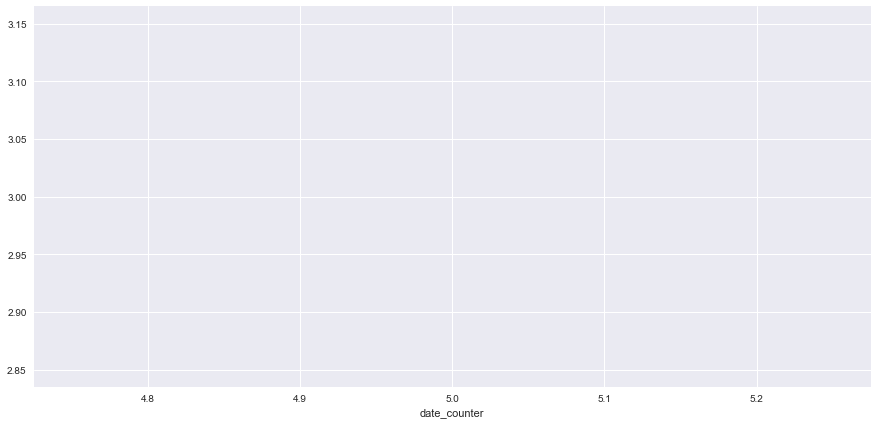

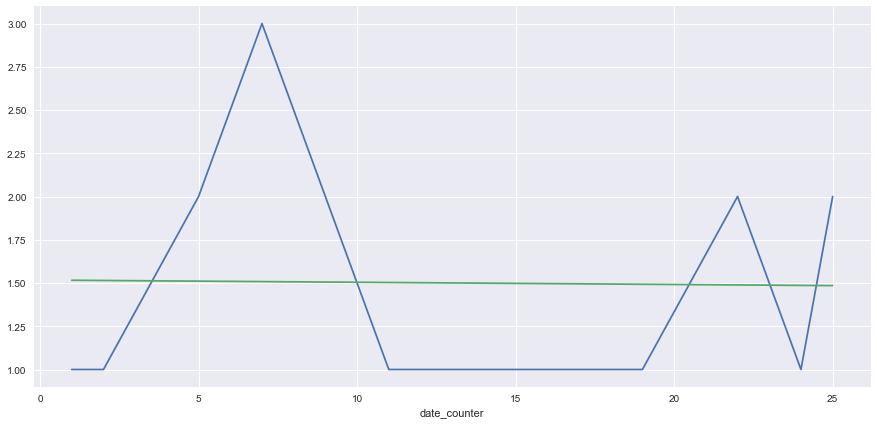

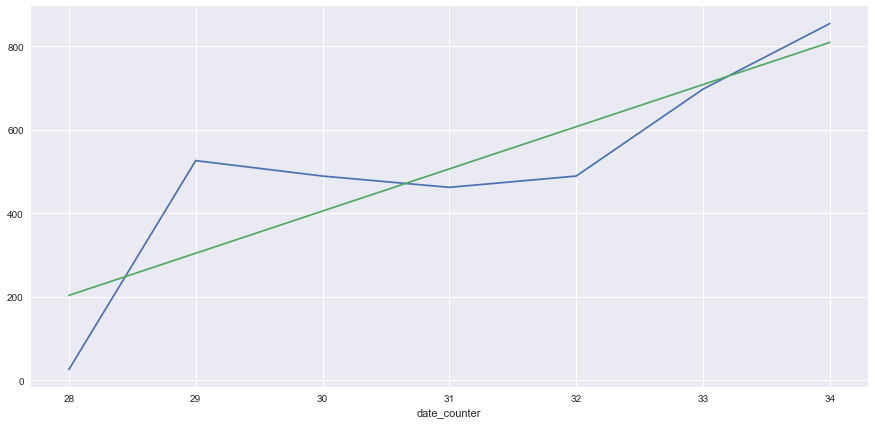

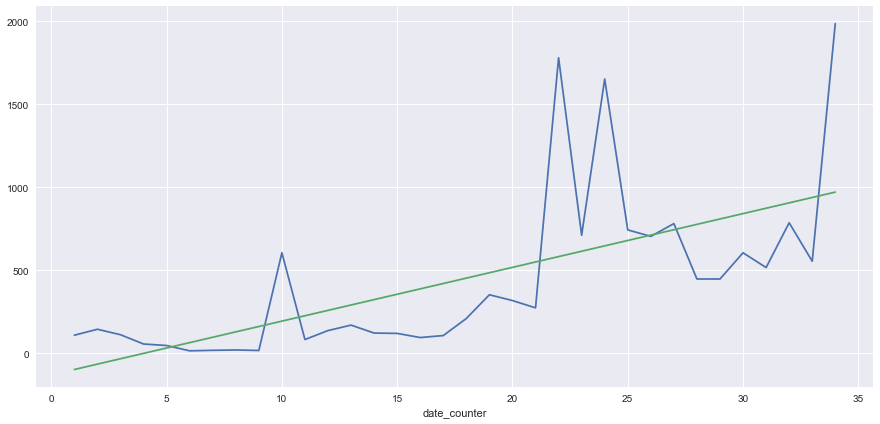

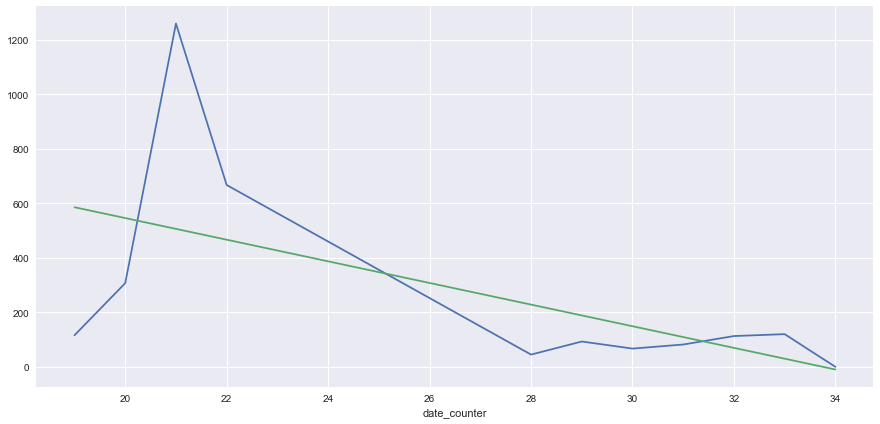

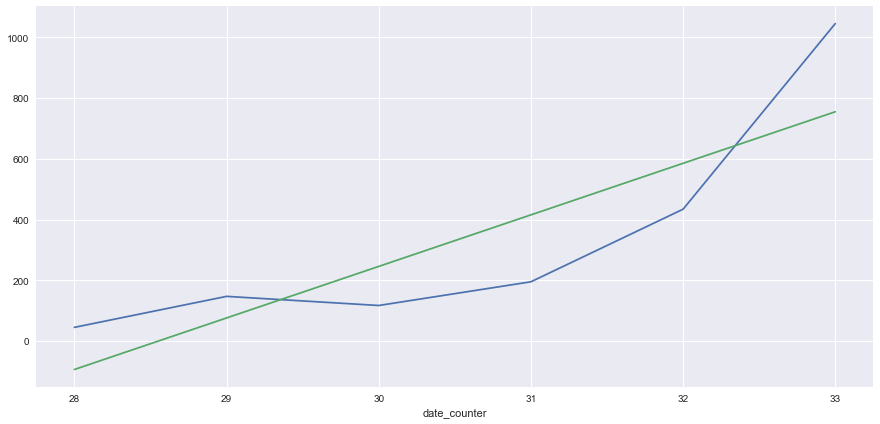

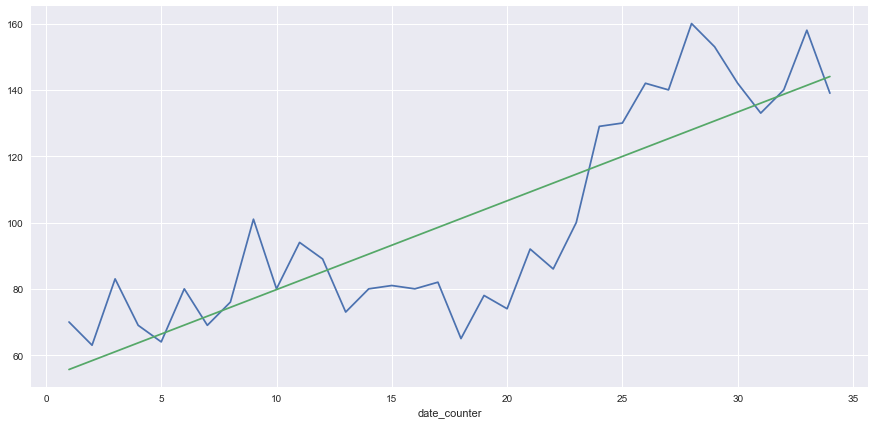

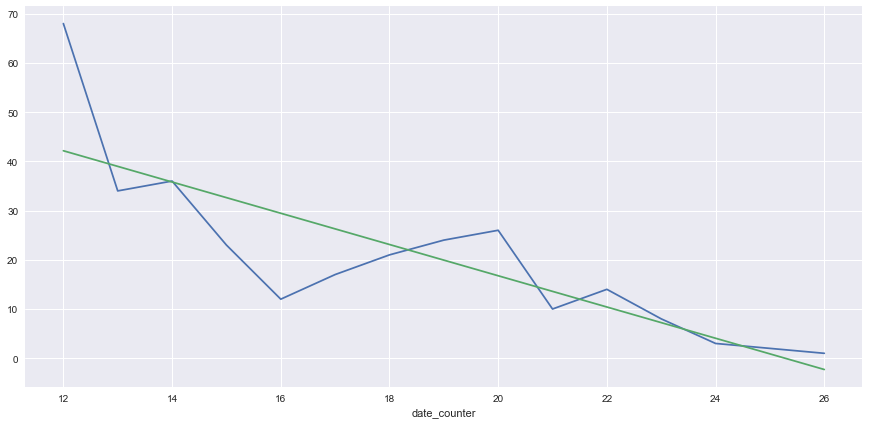

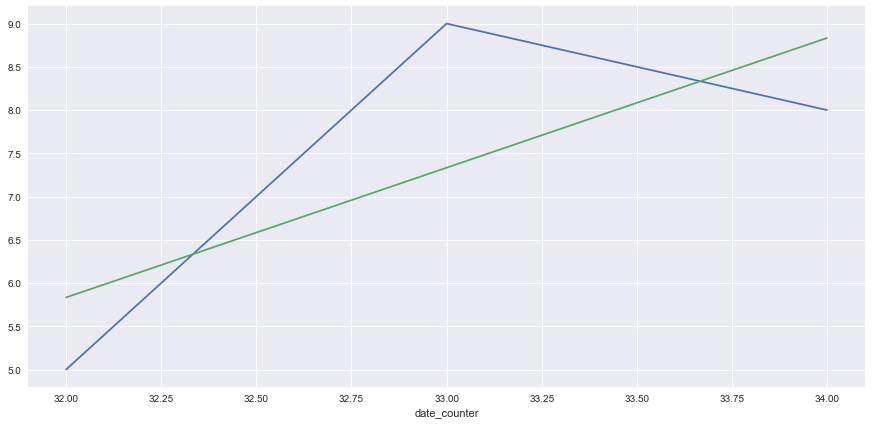

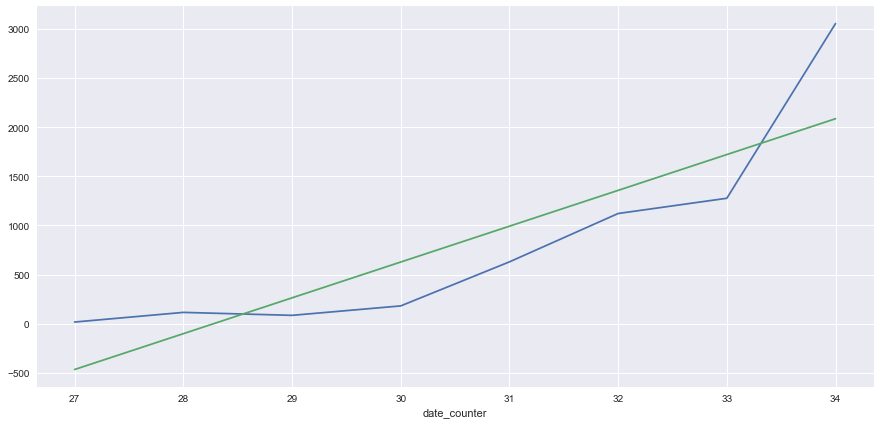

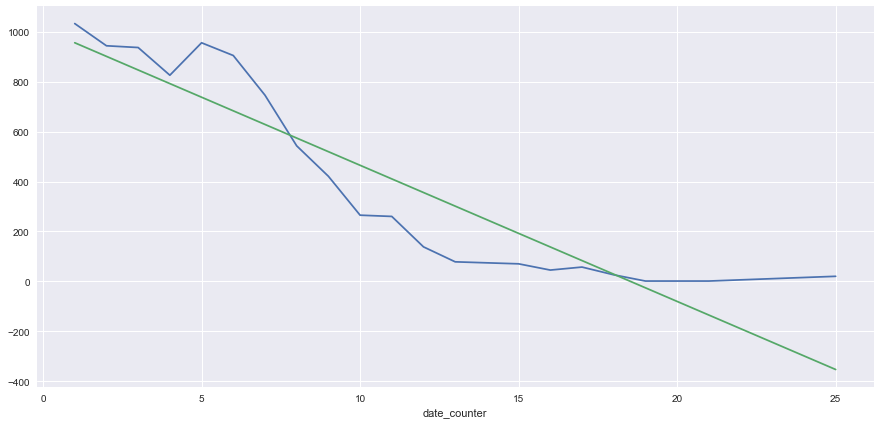

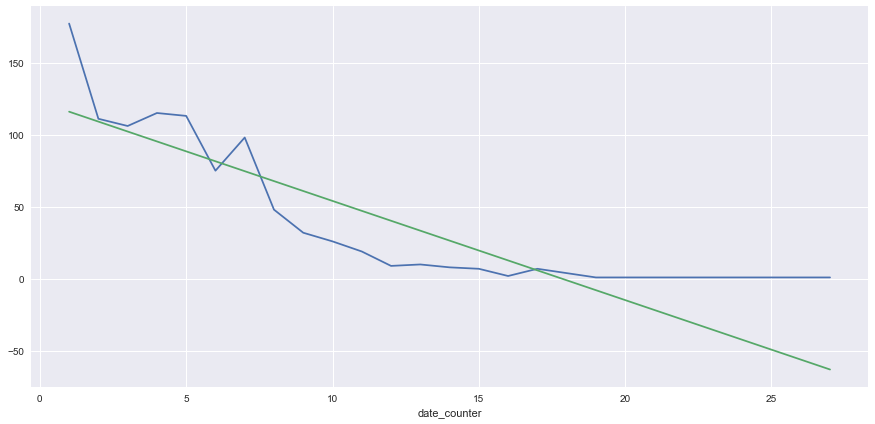

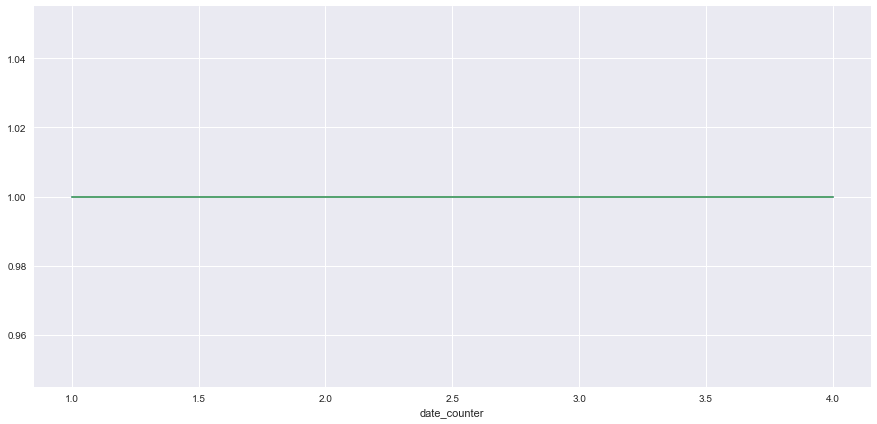

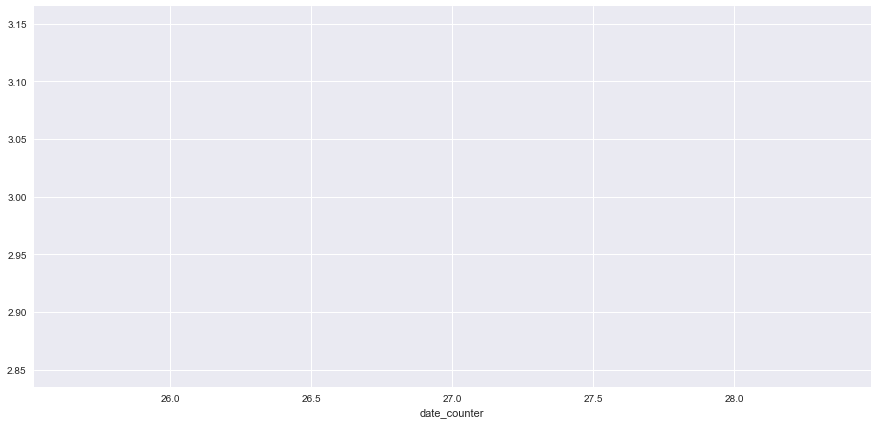

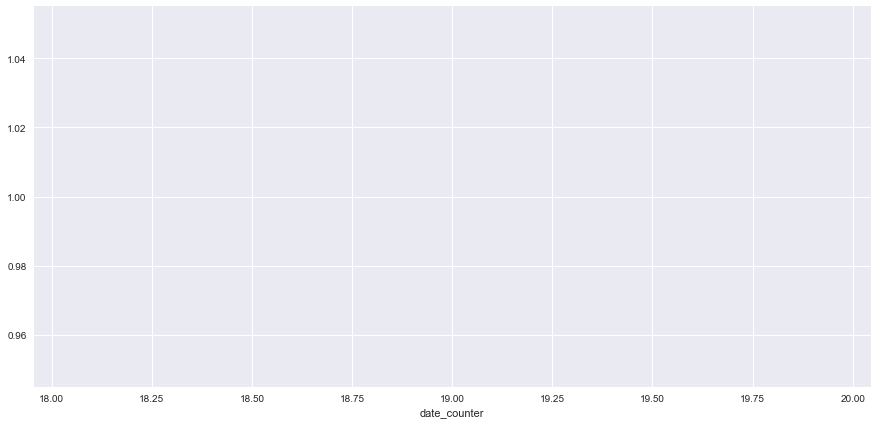

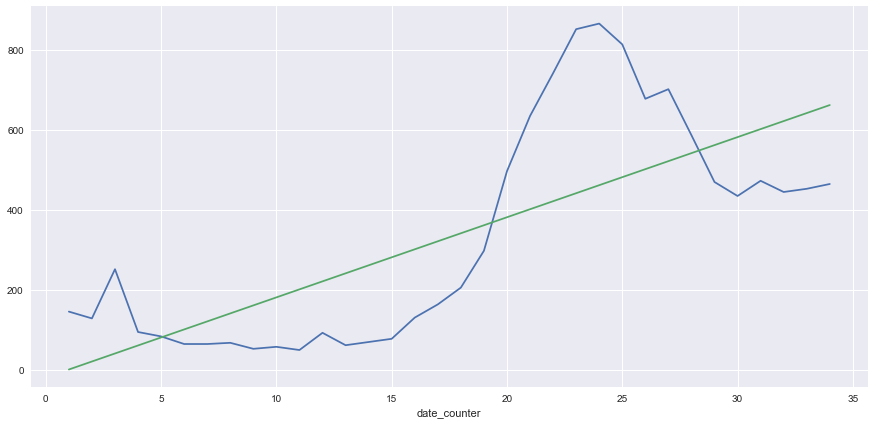

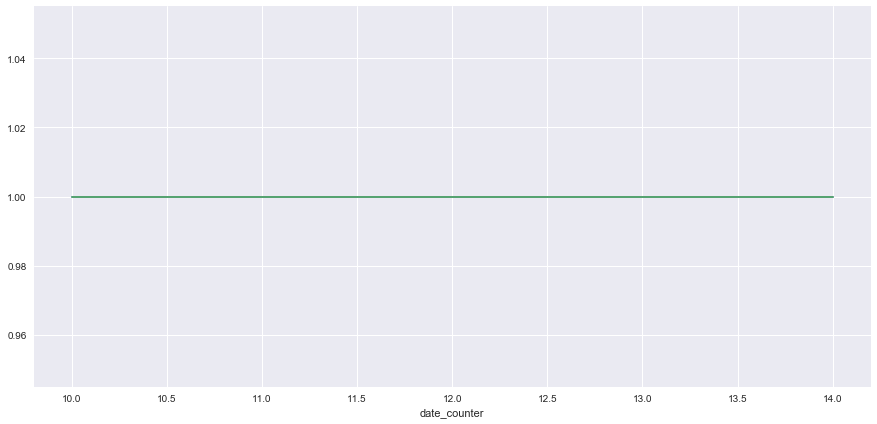

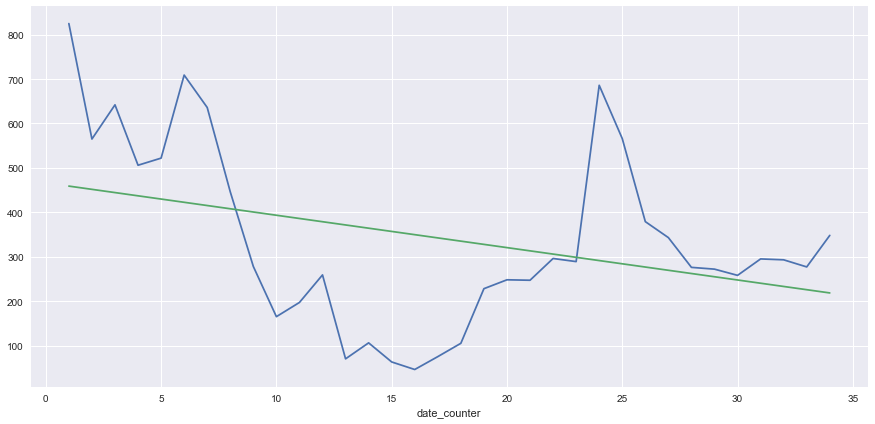

In [211]:
category_ids = w_cat_ids.item_category_id.unique()

for category_id in category_ids:
    get_coeffs_for_category(category_id, poly_degree=1, print_chart=True)

In [219]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [231]:
total = w_cat_ids.item_cnt_month.sum()

sums = pd.DataFrame(w_cat_ids.groupby('item_id')['item_cnt_month'].sum().reset_index(name ='item_sum'))

sums['percentage_of_total'] = sums['item_sum'] * 100 / total



C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'item_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


item_id  item_sum  percentage_of_total
0        0       1.0             0.000031
1        1       6.0             0.000184
2        2       2.0             0.000061
3        3       2.0             0.000061
4        4       1.0             0.000031

In [234]:
sums.sample(10)

item_id  item_sum  percentage_of_total
4310      4396     225.0             0.006913
3063      3125       1.0             0.000031
19032    19345     183.0             0.005622
21082    21434       6.0             0.000184
14242    14500     238.0             0.007312
1471      1504      97.0             0.002980
13897    14154       5.0             0.000154
19541    19858     216.0             0.006636
5613      5715       4.0             0.000123
192        196       2.0             0.000061

In [237]:
p = get_coeffs_for_shop(50)

In [245]:
global_pred = p(35)
item_share = sums[sums.item_id == 30]['percentage_of_total']

pred = global_pred * item_share

pred

30    26.776579
Name: percentage_of_total, dtype: float64

In [246]:
test_w_cat_ids

ID  item_cnt_month
item_id                       
30        2587        0.000000
30        7687        0.000000
30       12787        0.000000
30       17887        0.000000
30       22987        0.149741

In [240]:
test_w_cat_ids[test_w_cat_ids.shop_id == 50]['item_id']

item_id
30          30
31          31
32          32
33          33
38          38
42          42
45          45
51          51
53          53
57          57
59          59
62          62
64          64
67          67
69          69
70          70
72          72
76          76
80          80
83          83
88          88
91          91
93          93
109        109
138        138
140        140
149        149
153        153
154        154
166        166
         ...  
22022    22022
22035    22035
22050    22050
22054    22054
22059    22059
22060    22060
22068    22068
22069    22069
22071    22071
22087    22087
22088    22088
22091    22091
22092    22092
22100    22100
22101    22101
22102    22102
22104    22104
22105    22105
22106    22106
22111    22111
22118    22118
22137    22137
22139    22139
22145    22145
22154    22154
22162    22162
22163    22163
22164    22164
22166    22166
22167    22167
Name: item_id, Length: 5100, dtype: int64